In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import math 
import scipy

from matplotlib.dates import DateFormatter
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error
from glob import glob
from os import path
from collections import defaultdict
from skspatial.objects import Plane
from skspatial.objects import Points
from skspatial.plotting import plot_3d
from virocon import (
    GlobalHierarchicalModel,
    ExponentiatedWeibullDistribution,
    WeibullDistribution,
    DependenceFunction,
    WidthOfIntervalSlicer,
    plot_marginal_quantiles,
    plot_dependence_functions,
    _fitting
)

from virocon._fitting import (
    fit_function,
    fit_constrained_function,
    convert_bounds_for_curve_fit,
)

import sys
sys.path.insert(0, path.abspath(path.join(path.curdir, '../src')))

%matplotlib notebook

# Data

In [2]:
# Read data

data = pd.read_csv('/Volumes/MASTERTHESE/MasterThese/data_unsorted.csv')
data= data.drop(columns=['Unnamed: 0'])
data= data.rename(columns={"peakDeflection": "peakDeflectionSBIT"})
print(data)

      windSpeed  waveHeight  waveTp  waveTz  peakDeflectionSBIT  \
0      4.064444        1.39    7.14   5.263              2.7032   
1      3.959574        1.39    7.14   5.263              2.7870   
2      3.863043        1.39    7.14   5.263              3.6654   
3      3.744186        1.39    7.14   5.263              3.7484   
4      3.872340        1.39    7.14   5.263              4.8689   
...         ...         ...     ...     ...                 ...   
1267   3.991071        0.43    5.88   3.030              4.7862   
1268   4.268966        0.43    5.88   3.030              2.1788   
1269   3.841071        0.43    5.88   3.030              3.7424   
1270   4.678333        0.43    5.88   3.030              1.4381   
1271   4.188136        0.43    5.88   3.030              1.6619   

      peakDeflectionTower  
0                 15.6301  
1                 17.3423  
2                 14.7588  
3                 22.1884  
4                 15.9363  
...                   ...  

<IPython.core.display.Javascript object>


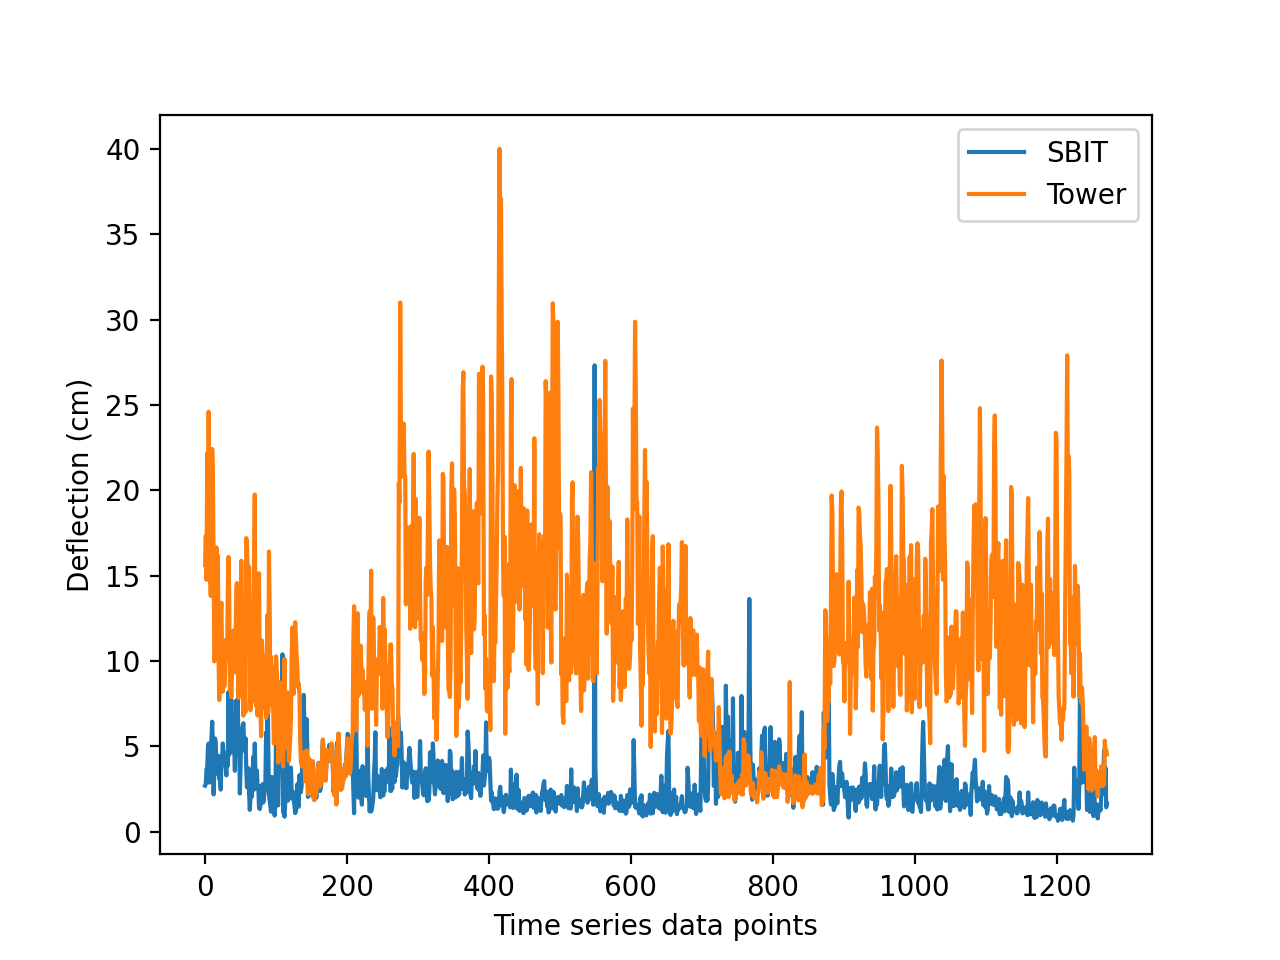

In [3]:
plt.figure()
plt.plot(data.peakDeflectionSBIT, label='SBIT')
plt.plot(data.peakDeflectionTower, label='Tower')
plt.xlabel('Time series data points')
plt.ylabel('Deflection (cm)')
plt.legend()

In [4]:
data = data.drop(data[(data.peakDeflectionTower- data.peakDeflectionSBIT) < 5].index)
data = data[data['windSpeed'].notna()]
data= data.reset_index(drop=True)
print(data)

     windSpeed  waveHeight  waveTp  waveTz  peakDeflectionSBIT  \
0     4.064444        1.39    7.14   5.263              2.7032   
1     3.959574        1.39    7.14   5.263              2.7870   
2     3.863043        1.39    7.14   5.263              3.6654   
3     3.744186        1.39    7.14   5.263              3.7484   
4     3.872340        1.39    7.14   5.263              4.8689   
..         ...         ...     ...     ...                 ...   
795   3.237931        0.54    4.35   3.361              2.8250   
796   3.827119        0.54    4.35   3.361              2.9406   
797   3.351724        0.54    4.35   3.361              1.3385   
798   3.532203        0.54    4.35   3.361              2.5891   
799   4.589655        0.54    4.35   3.361              2.8813   

     peakDeflectionTower  
0                15.6301  
1                17.3423  
2                14.7588  
3                22.1884  
4                15.9363  
..                   ...  
795              1

<IPython.core.display.Javascript object>


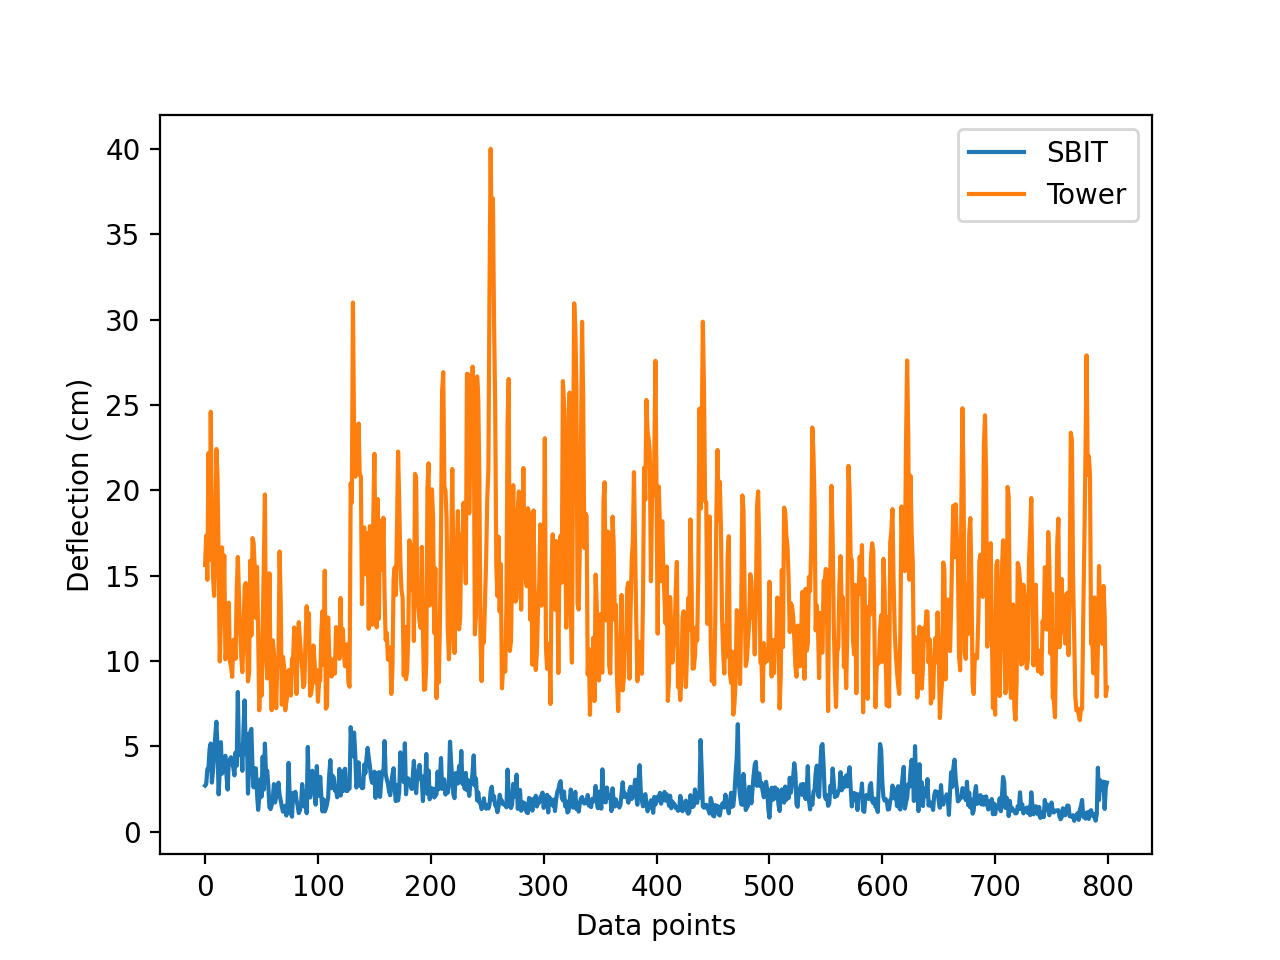

In [5]:
plt.figure()
plt.plot(data.peakDeflectionSBIT, label='SBIT')
plt.plot(data.peakDeflectionTower, label='Tower')
plt.xlabel('Data points')
plt.ylabel('Deflection (cm)')
plt.legend()

# Histogram

In [6]:
# set up the histogramm, 60 steps= bin size of 0,5 cm deflection
bins = np.linspace(0, 40, 80)
bin_centers = 0.5*(bins[1:] + bins[:-1])

# fit GEV and weibull distribution to data
gev_fit_tower= stats.genextreme.fit(data.peakDeflectionTower)
gev_pdf_tower= stats.genextreme.pdf(bin_centers, gev_fit_tower[0], loc= gev_fit_tower[1], scale= gev_fit_tower[2])
gev_ppf_tower= stats.genextreme.ppf(bin_centers, gev_fit_tower[0], loc= gev_fit_tower[1], scale= gev_fit_tower[2])
gev_cdf_tower= stats.genextreme.cdf(bin_centers, gev_fit_tower[0], loc= gev_fit_tower[1], scale= gev_fit_tower[2])

#weib_fit = stats.weibull_min.fit(data.deflection)
#weib_cdf= stats.weibull_min.cdf(bin_centers, weib_fit[0], loc= weib_fit[1], scale= weib_fit[2])

#print(weib_fit)
print(gev_fit_tower)

(-0.1118007401397142, 11.45977029288046, 3.496913938662952)


<IPython.core.display.Javascript object>


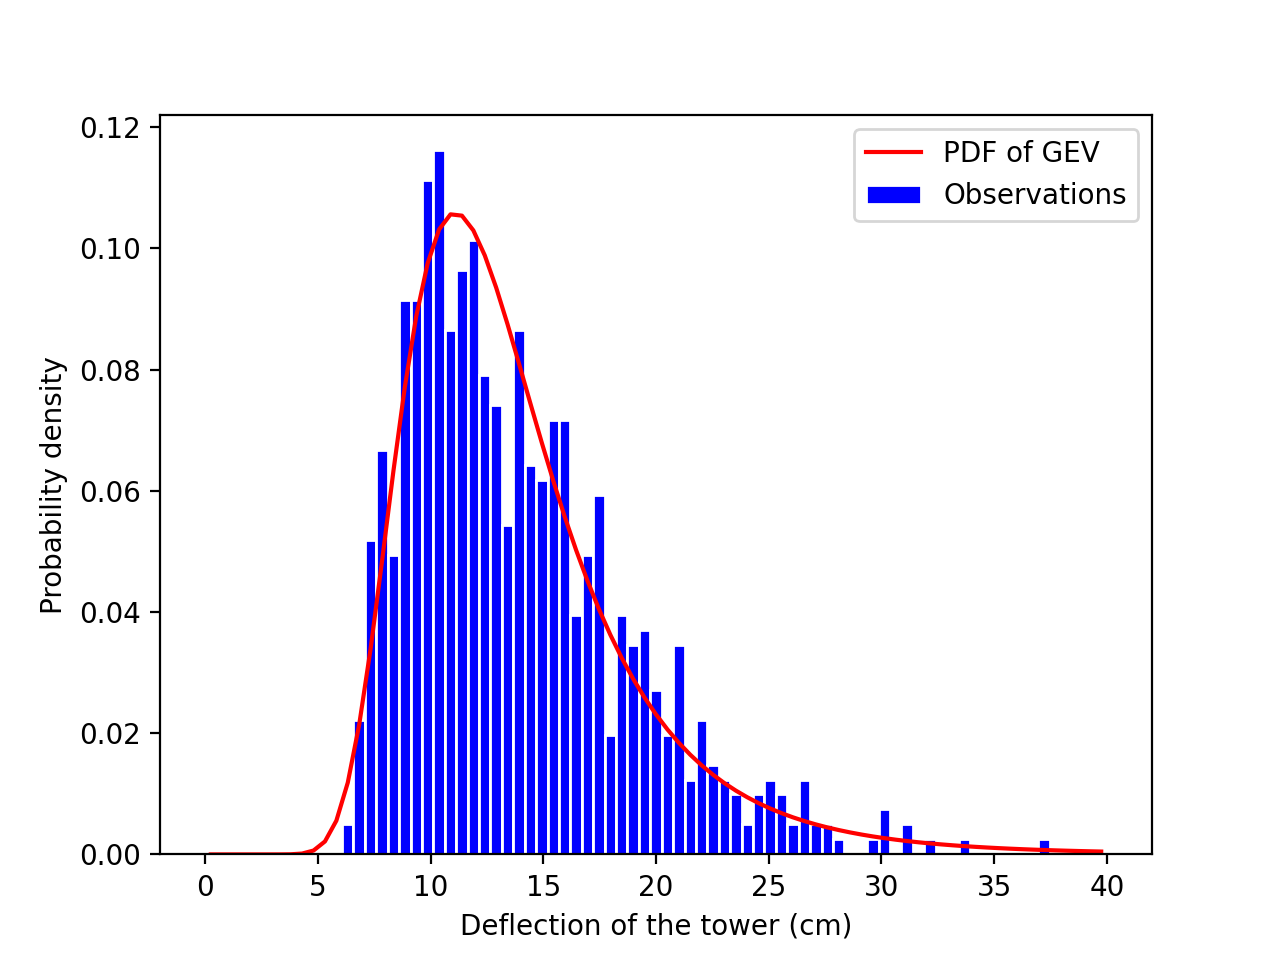

In [7]:
fig, ax1 = plt.subplots()

ax1.hist(data.peakDeflectionTower, bins=bins, label='Observations', color='b', density= 'true', stacked='true', edgecolor='w')
ax1.plot(bin_centers, gev_pdf_tower, label="PDF of GEV", color='r')
ax1.set_xlabel('Deflection of the tower (cm)')
ax1.set_ylabel('Probability density')

ax1.legend()

plt.show()

<IPython.core.display.Javascript object>


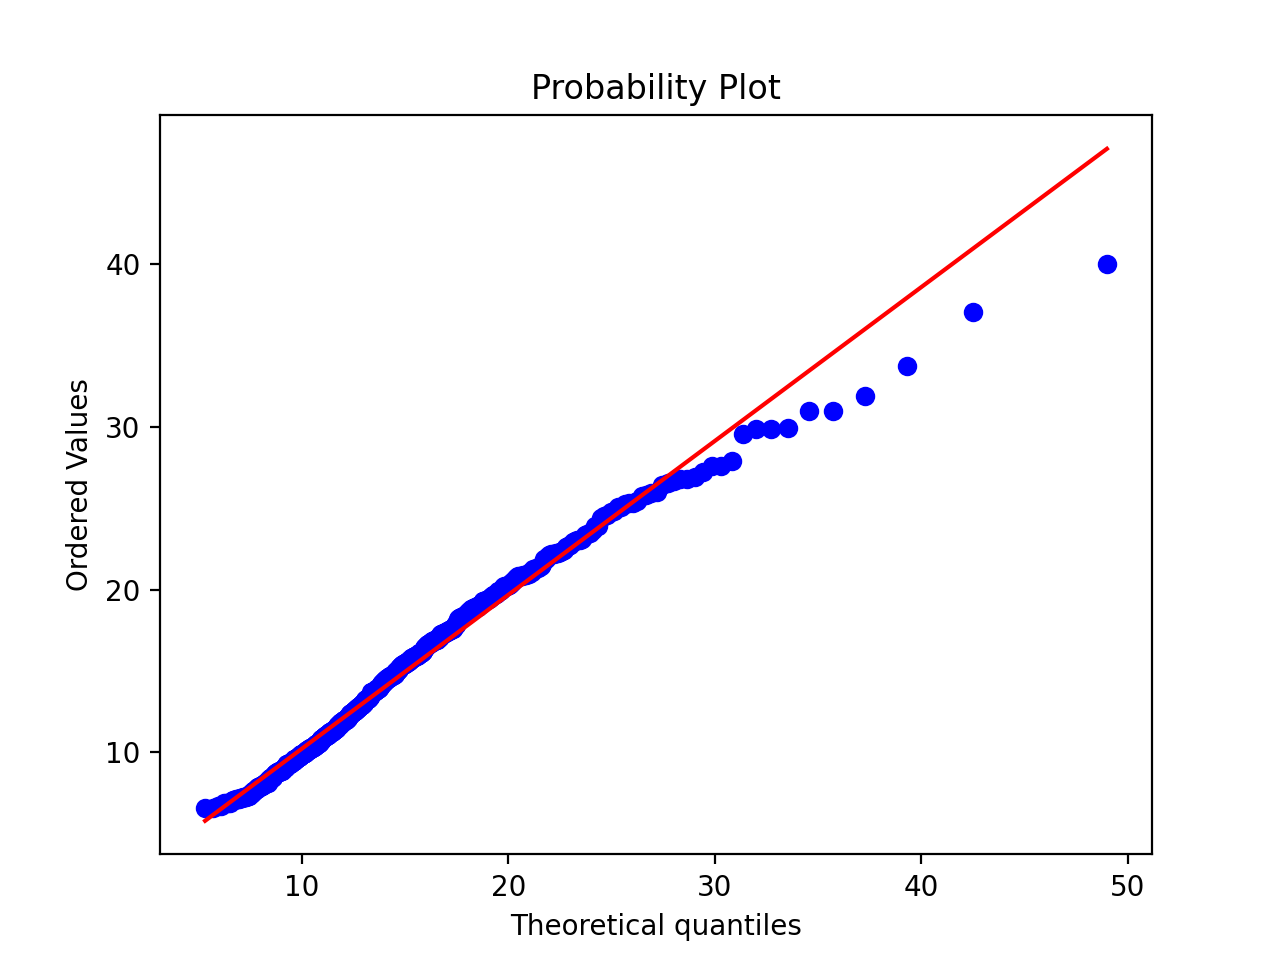

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(data.peakDeflectionTower, (gev_fit_tower[0], gev_fit_tower[1], gev_fit_tower[2]), dist='genextreme', plot=ax)
#ax.set_title("Probability plot of sample data against the quantiles of a specified theoretical distribution.")
plt.show()

# Scatter Plots

<IPython.core.display.Javascript object>


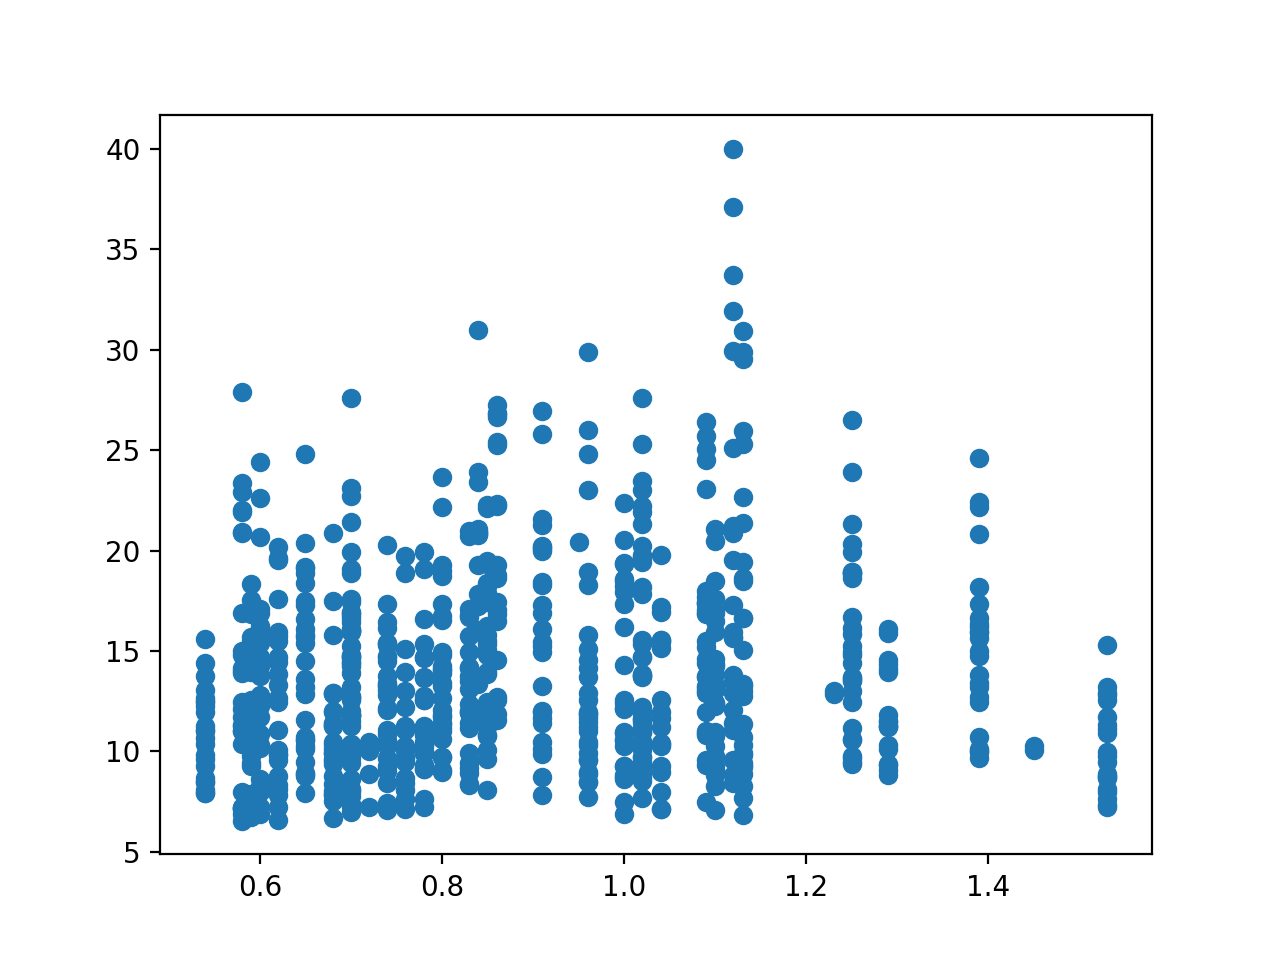

In [9]:
plt.figure()
plt.scatter(data.waveHeight, data.peakDeflectionTower)

<IPython.core.display.Javascript object>


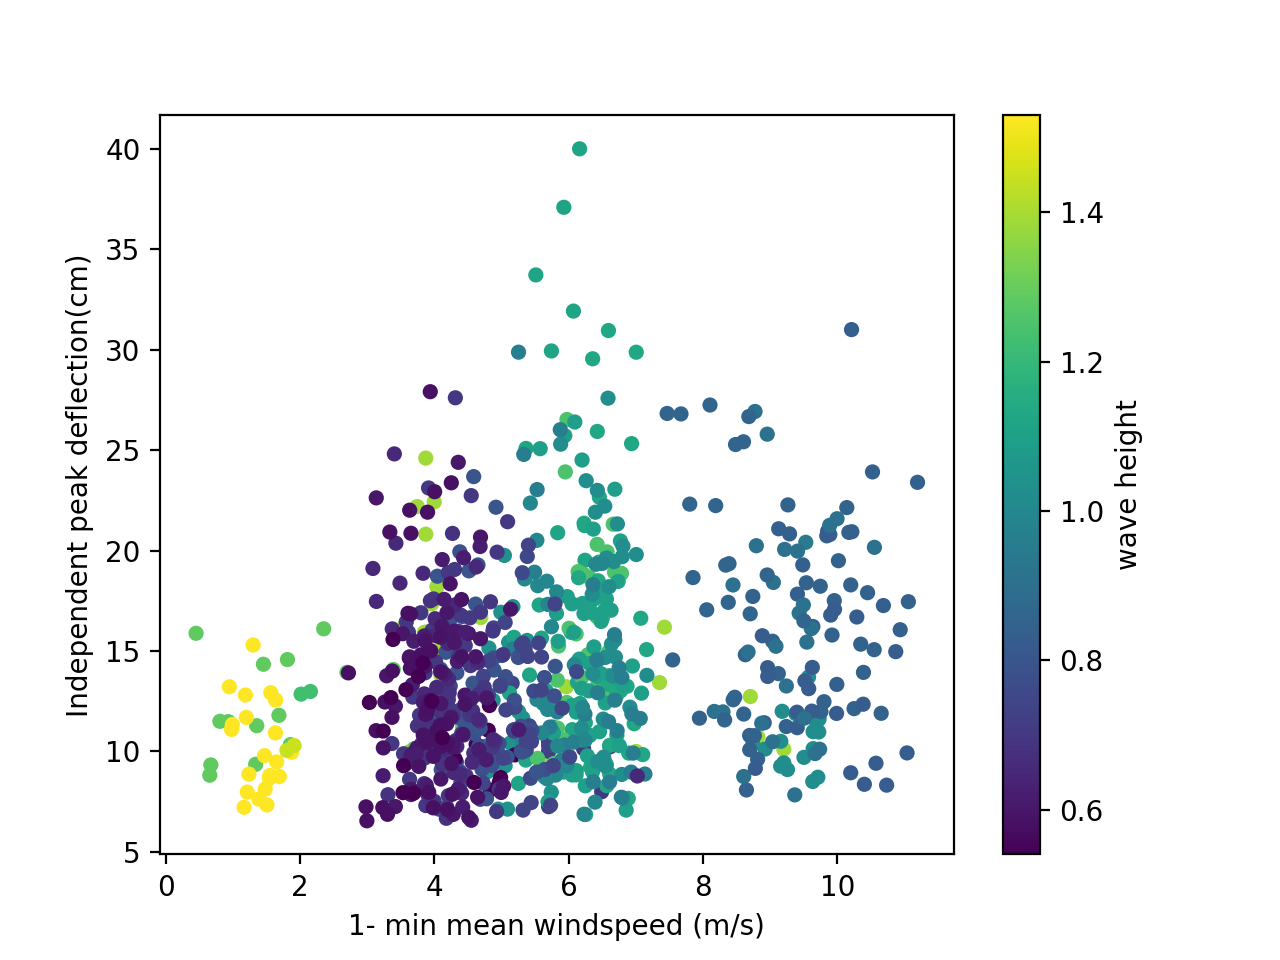

In [10]:
fig, ax1 = plt.subplots(1)
scatter= ax1.scatter(data.windSpeed, data.peakDeflectionTower, s=20, c=data.waveHeight)
ax1.set_xlabel('1- min mean windspeed (m/s)')
ax1.set_ylabel('Independent peak deflection(cm)')
fig.colorbar(scatter,label='wave height')

<IPython.core.display.Javascript object>


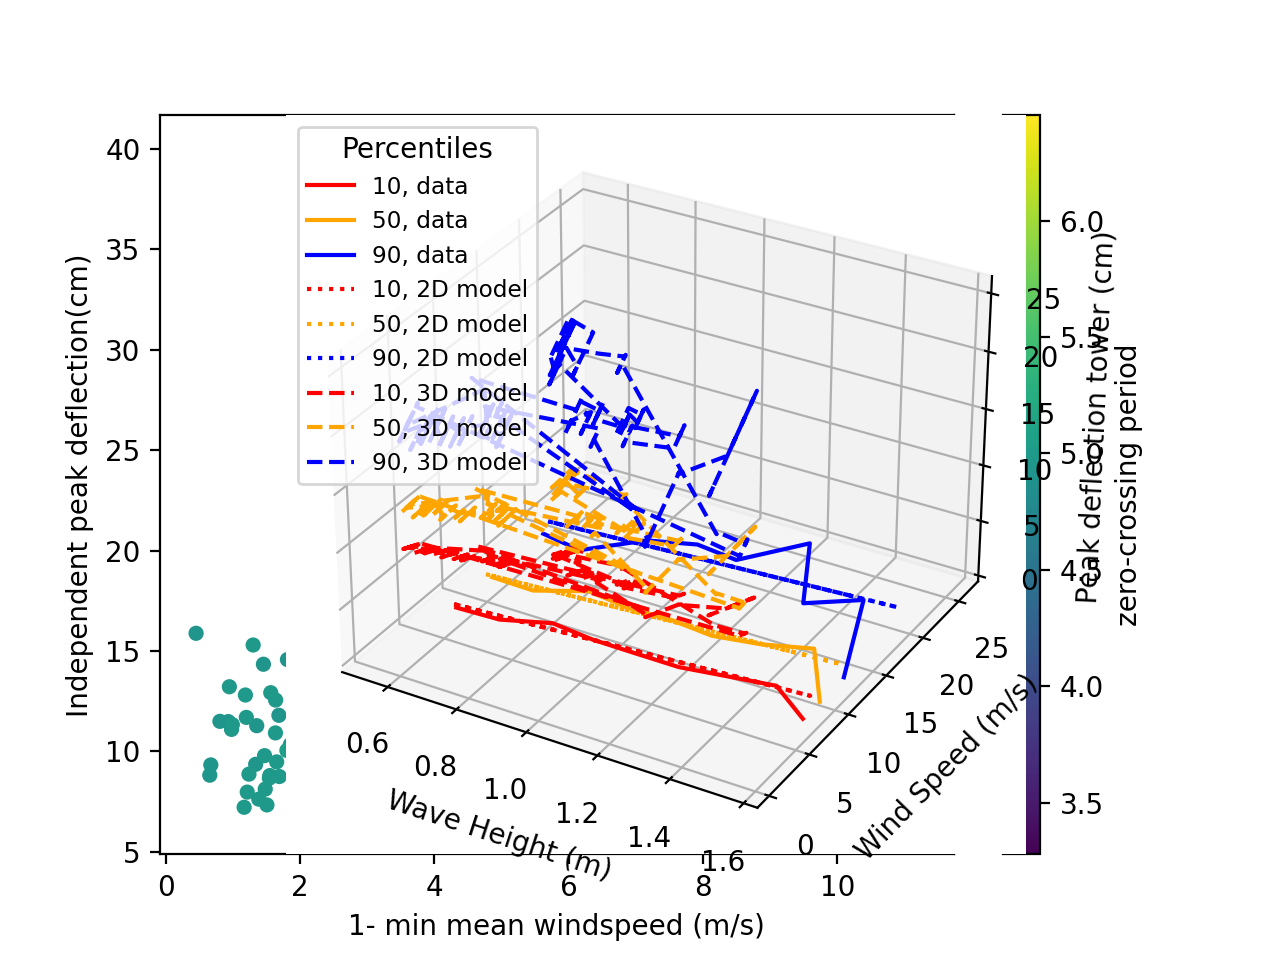

In [11]:
fig, ax1 = plt.subplots(1)
scatter= ax1.scatter(data.windSpeed, data.peakDeflectionTower, s=20, c=data.waveTz)
ax1.set_xlabel('1- min mean windspeed (m/s)')
ax1.set_ylabel('Independent peak deflection(cm)')
fig.colorbar(scatter,label='zero-crossing period')

<IPython.core.display.Javascript object>


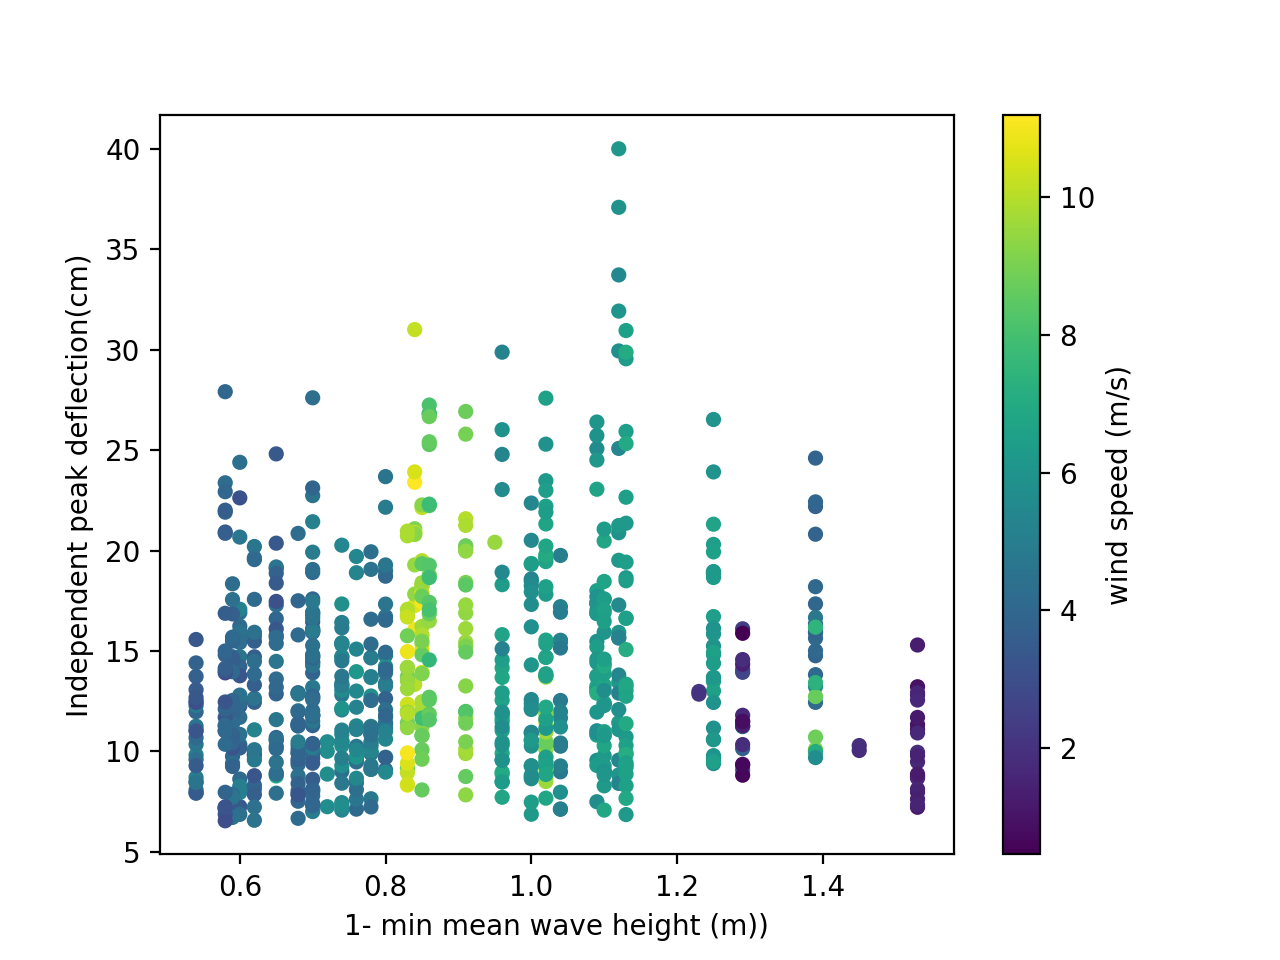

In [12]:
fig, ax1 = plt.subplots(1)
scatter= ax1.scatter(data.waveHeight, data.peakDeflectionTower, s=20, c=data.windSpeed)
ax1.set_xlabel('1- min mean wave height (m))')
ax1.set_ylabel('Independent peak deflection(cm)')
fig.colorbar(scatter,label='wind speed (m/s)')

<IPython.core.display.Javascript object>


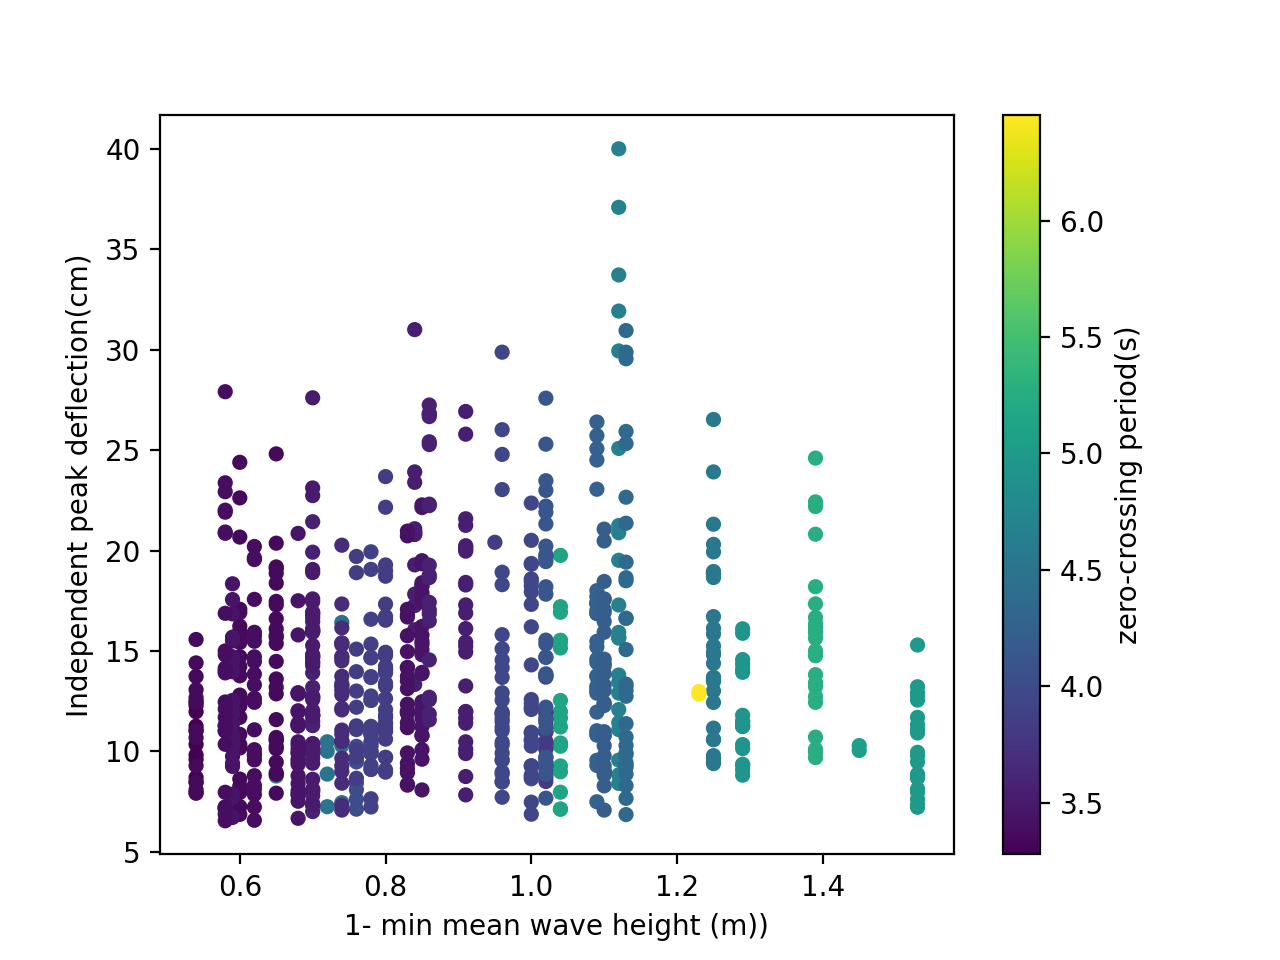

In [13]:
fig, ax1 = plt.subplots(1)
scatter= ax1.scatter(data.waveHeight, data.peakDeflectionTower, s=20, c=data.waveTz)
ax1.set_xlabel('1- min mean wave height (m))')
ax1.set_ylabel('Independent peak deflection(cm)')
fig.colorbar(scatter,label='zero-crossing period(s)')

# Interval Slicer

In [14]:
width_slicer_V = WidthOfIntervalSlicer(width=1, reference="center", min_n_points=1)
width_slicer_Hs = WidthOfIntervalSlicer(width=0.125, reference="center", min_n_points=1)
#width_slicer_Tz = WidthOfIntervalSlicer(width=0.5, reference="right", min_n_points=1)

wind_slices, wind_references, wind_boundaries = width_slicer_V.slice_(data.windSpeed)
waveH_slices, waveH_references, waveH_boundaries = width_slicer_Hs.slice_(data.waveHeight)
#waveTz_slices, waveTz_references, waveTz_boundaries = width_slicer_Tz.slice_(data.waveTz)

In [15]:
print(waveH_boundaries)
print(wind_boundaries)

[(0.5, 0.625), (0.625, 0.75), (0.75, 0.875), (0.875, 1.0), (1.0, 1.125), (1.125, 1.25), (1.25, 1.375), (1.375, 1.5), (1.5, 1.625)]
[(0.0, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0), (5.0, 6.0), (6.0, 7.0), (7.0, 8.0), (8.0, 9.0), (9.0, 10.0), (10.0, 11.0), (11.0, 12.0)]


# Intervals data 1

In [16]:
# WIND SPEED

tower_defl_intervals_V= []
for i in range (len(wind_references)):
    tower_defl_intervals_V.append([])

for i in range(len(wind_slices)):
    for j in range(len(wind_slices[i])):
        if (data.windSpeed[j] >= wind_boundaries[i][0]) & (data.windSpeed[j] < wind_boundaries[i][1]) :
            tower_defl_intervals_V[i].append(data.peakDeflectionTower[j])          
            
# WAVE HEIGHT


tower_defl_intervals_Hs= []
for i in range (len(waveH_references)):
    tower_defl_intervals_Hs.append([])


for i in range(len(waveH_slices)):
    for j in range(len(waveH_slices[i])):
        if (data.waveHeight[j] >= waveH_boundaries[i][0]) & (data.waveHeight[j] < waveH_boundaries[i][1]):
            tower_defl_intervals_Hs[i].append(data.peakDeflectionTower[j])

#print(len(tower_defl_intervals_Hs[-1]))
# WAVE ZERO-CROSSING PERIOD


#tower_defl_intervals_Tz= []
#for i in range (len(waveTz_references)):
    #tower_defl_intervals_Tz.append([])


#for i in range(len(waveTz_slices)):
    #for j in range(len(waveTz_slices[i])):
        #if (data.waveTz[j] >= waveTz_boundaries[i][0]) & (data.waveTz[j] < waveTz_boundaries[i][1]):
            #tower_defl_intervals_Tz[i].append(data.peakDeflectionTower[j])

In [17]:
#for i in range(len(tower_defl_intervals_V)):
    #print(len(tower_defl_intervals_V[i]))

In [18]:
# Fit the parameters of the GEV conditional on intervals of V, Hs, Tz

# WIND SPEED

parameter_list_tower_V= []
for i in range (len(gev_fit_tower)):
    parameter_list_tower_V.append([])

for i in range(len(tower_defl_intervals_V)):
    fit= stats.genextreme.fit(tower_defl_intervals_V[i])
    parameter_list_tower_V[0].append(fit[0])
    parameter_list_tower_V[1].append(fit[1])
    parameter_list_tower_V[2].append(fit[2])

#print(len(parameter_list_tower_V[0]))

# WAVE HEIGHT

parameter_list_tower_Hs= []
for i in range (len(gev_fit_tower)):
    parameter_list_tower_Hs.append([])

for i in range(len(tower_defl_intervals_Hs)):
    fit= stats.genextreme.fit(tower_defl_intervals_Hs[i])
    parameter_list_tower_Hs[0].append(fit[0])
    parameter_list_tower_Hs[1].append(fit[1])
    parameter_list_tower_Hs[2].append(fit[2])

print(parameter_list_tower_Hs[1])

# ZERO CROSSING PERIOD

#parameter_list_tower_Tz= []
#for i in range (len(gev_fit_tower)):
    #parameter_list_tower_Tz.append([])

#for i in range(len(tower_defl_intervals_Tz)):
    #fit= stats.genextreme.fit(tower_defl_intervals_Tz[i])
    #parameter_list_tower_Tz[0].append(fit[0])
    #parameter_list_tower_Tz[1].append(fit[1])
    #parameter_list_tower_Tz[2].append(fit[2])

#print(len(parameter_list_tower_Tz[0]))

/Applications/anaconda3/envs/env_masterthese/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


[10.603879849852405, 10.949794539947495, 12.27275640174128, 12.03737281557076, 11.79515871014519, 11.64057550244864, 12.075682737020099, 12.985211006453195, 9.157453068311423]


# Dependency Shape parameter

<IPython.core.display.Javascript object>


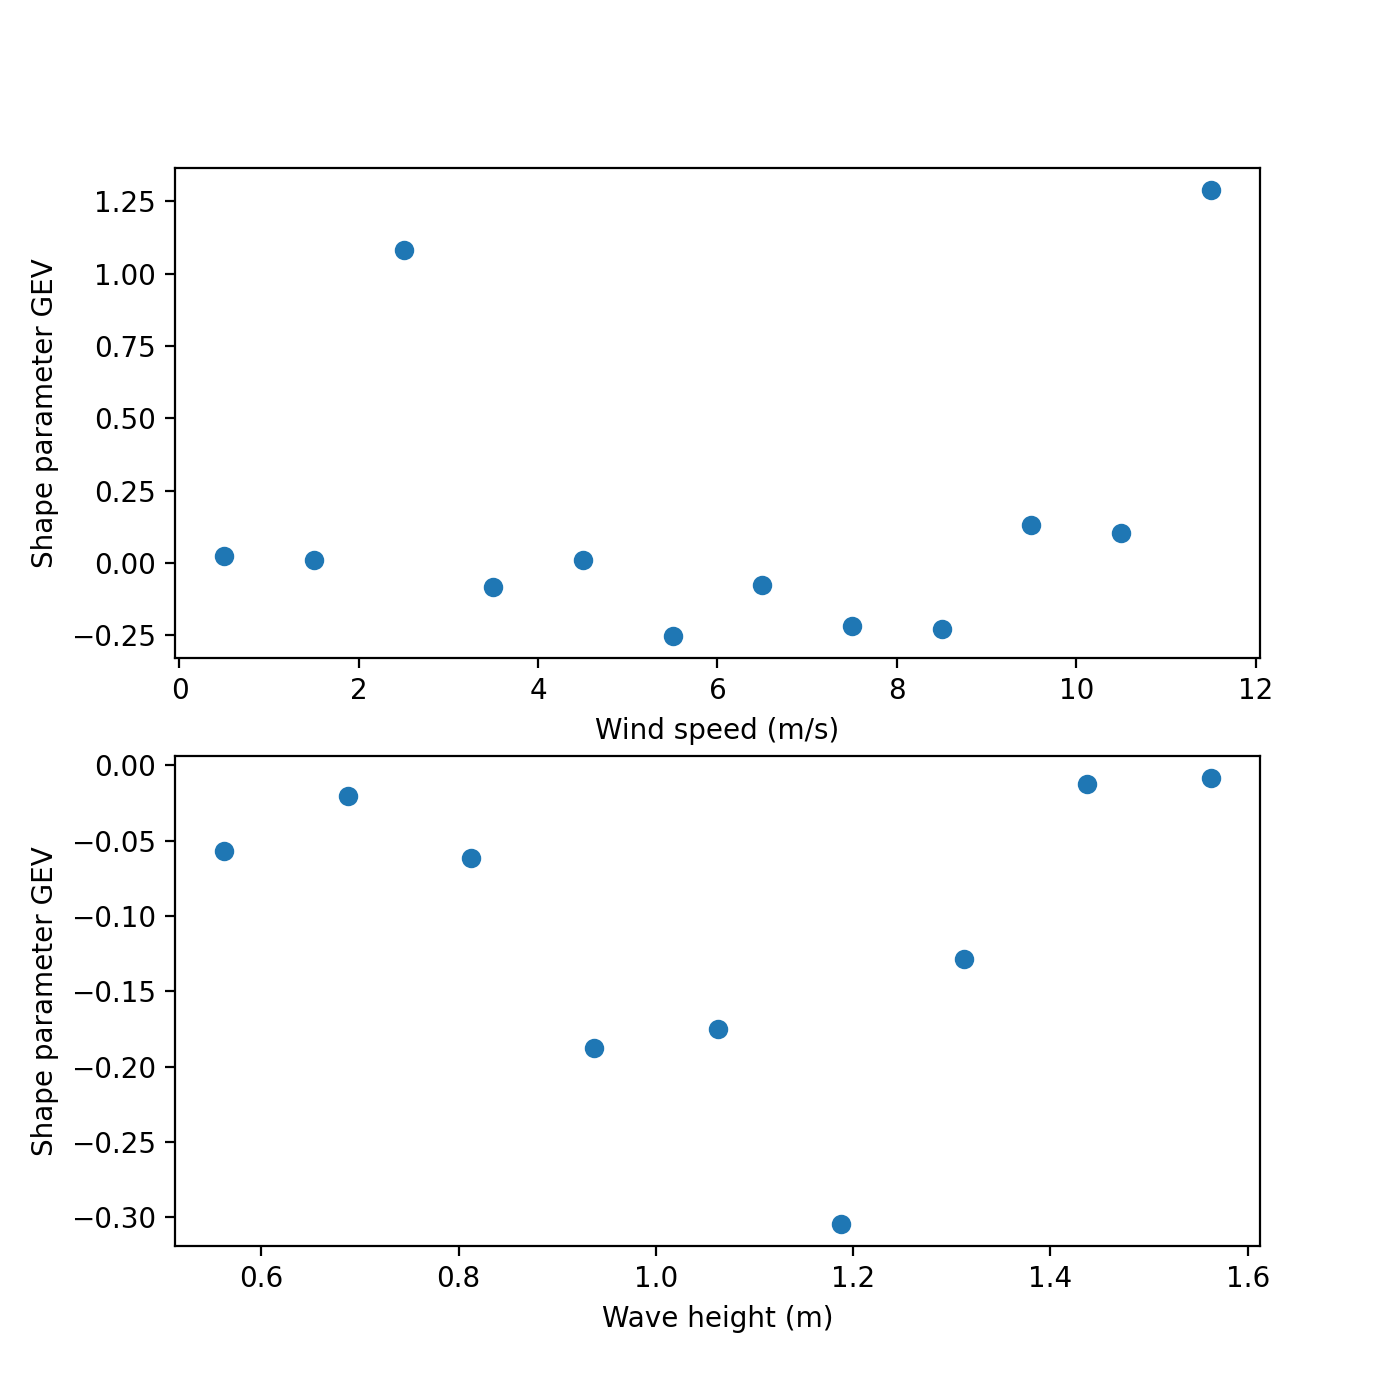

Text(0, 0.5, 'Shape parameter GEV')

In [19]:
fig, (ax1, ax2) = plt.subplots(2, sharex= False, figsize=(7,7))
ax1.scatter(wind_references, parameter_list_tower_V[0])
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Shape parameter GEV')
ax2.scatter(waveH_references, parameter_list_tower_Hs[0])
ax2.set_xlabel('Wave height (m)')
ax2.set_ylabel('Shape parameter GEV')

# Dependency Location parameter

<IPython.core.display.Javascript object>


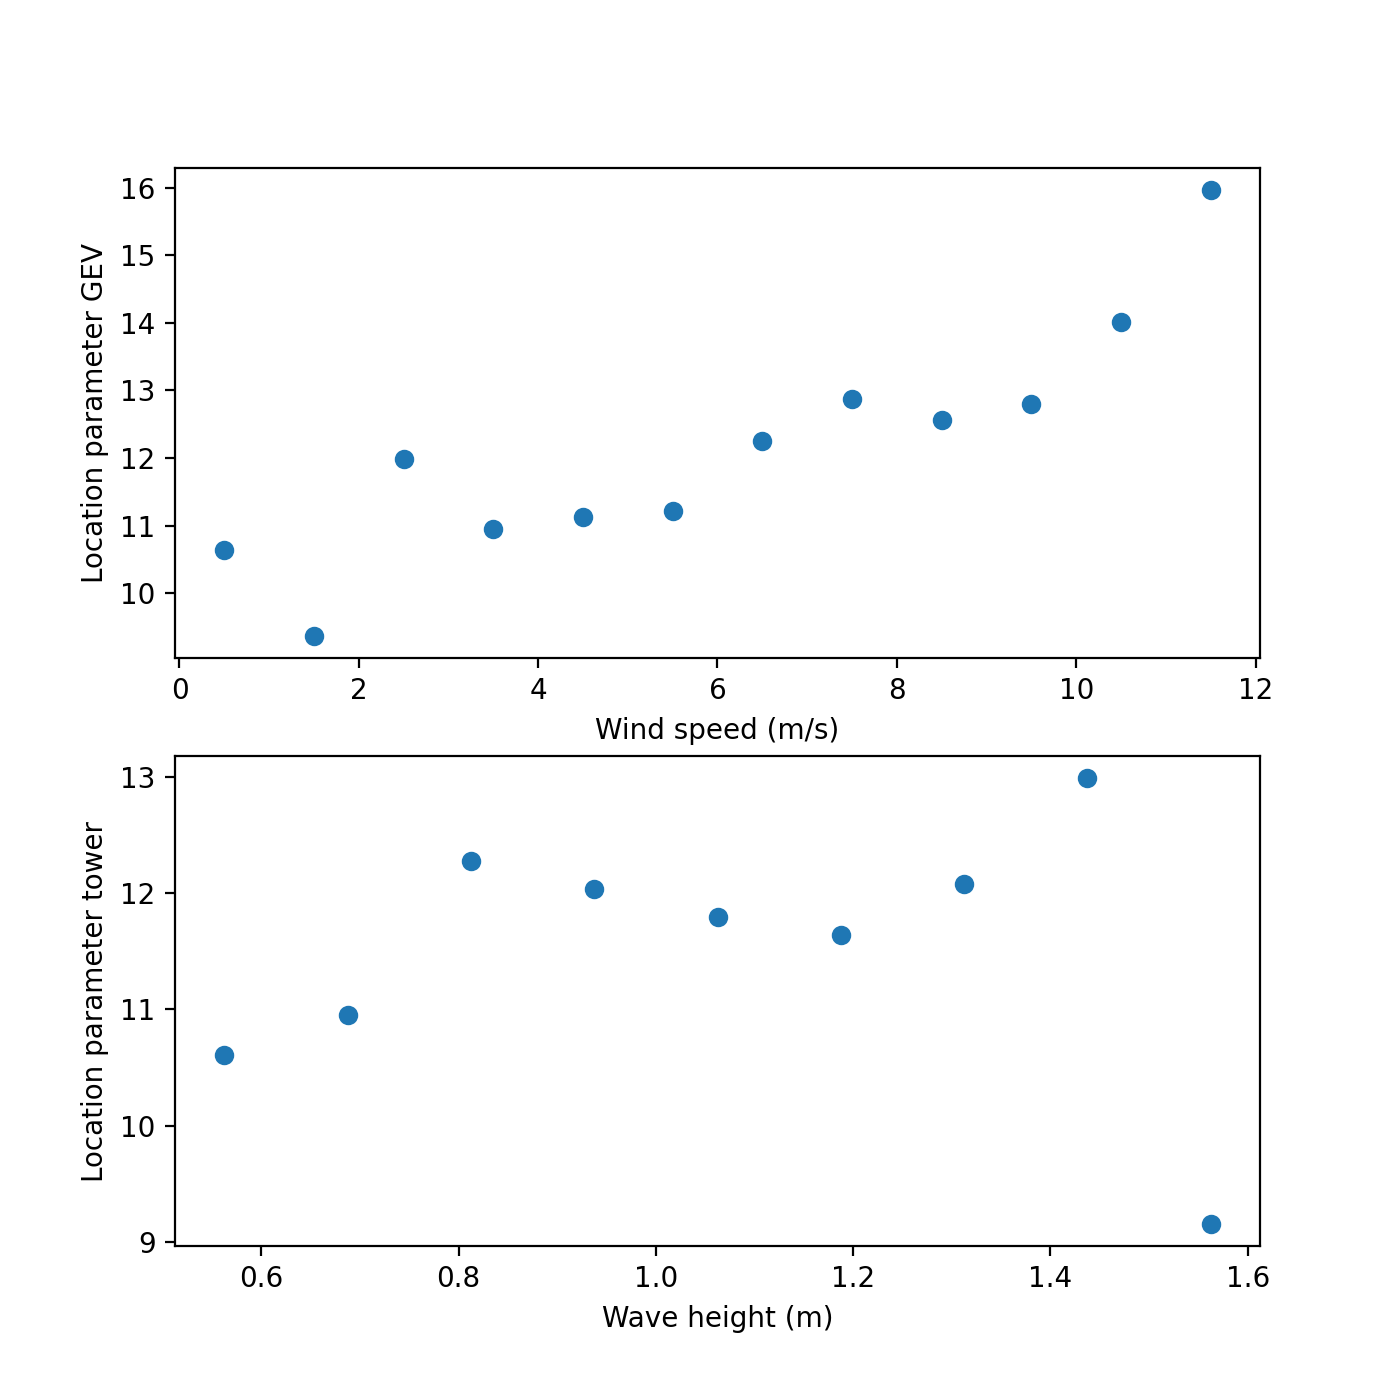

Text(0, 0.5, 'Location parameter tower')

In [20]:
fig, (ax1, ax2) = plt.subplots(2, sharex= False, figsize=(7,7))
ax1.scatter(wind_references, parameter_list_tower_V[1])
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Location parameter GEV')

ax2.scatter(waveH_references, parameter_list_tower_Hs[1])
ax2.set_xlabel('Wave height (m)')
ax2.set_ylabel('Location parameter tower')

In [21]:
parameter_list_tower_Hs[1][-1]= parameter_list_tower_Hs[1][-2]

# Dependency Scale parameter

<IPython.core.display.Javascript object>


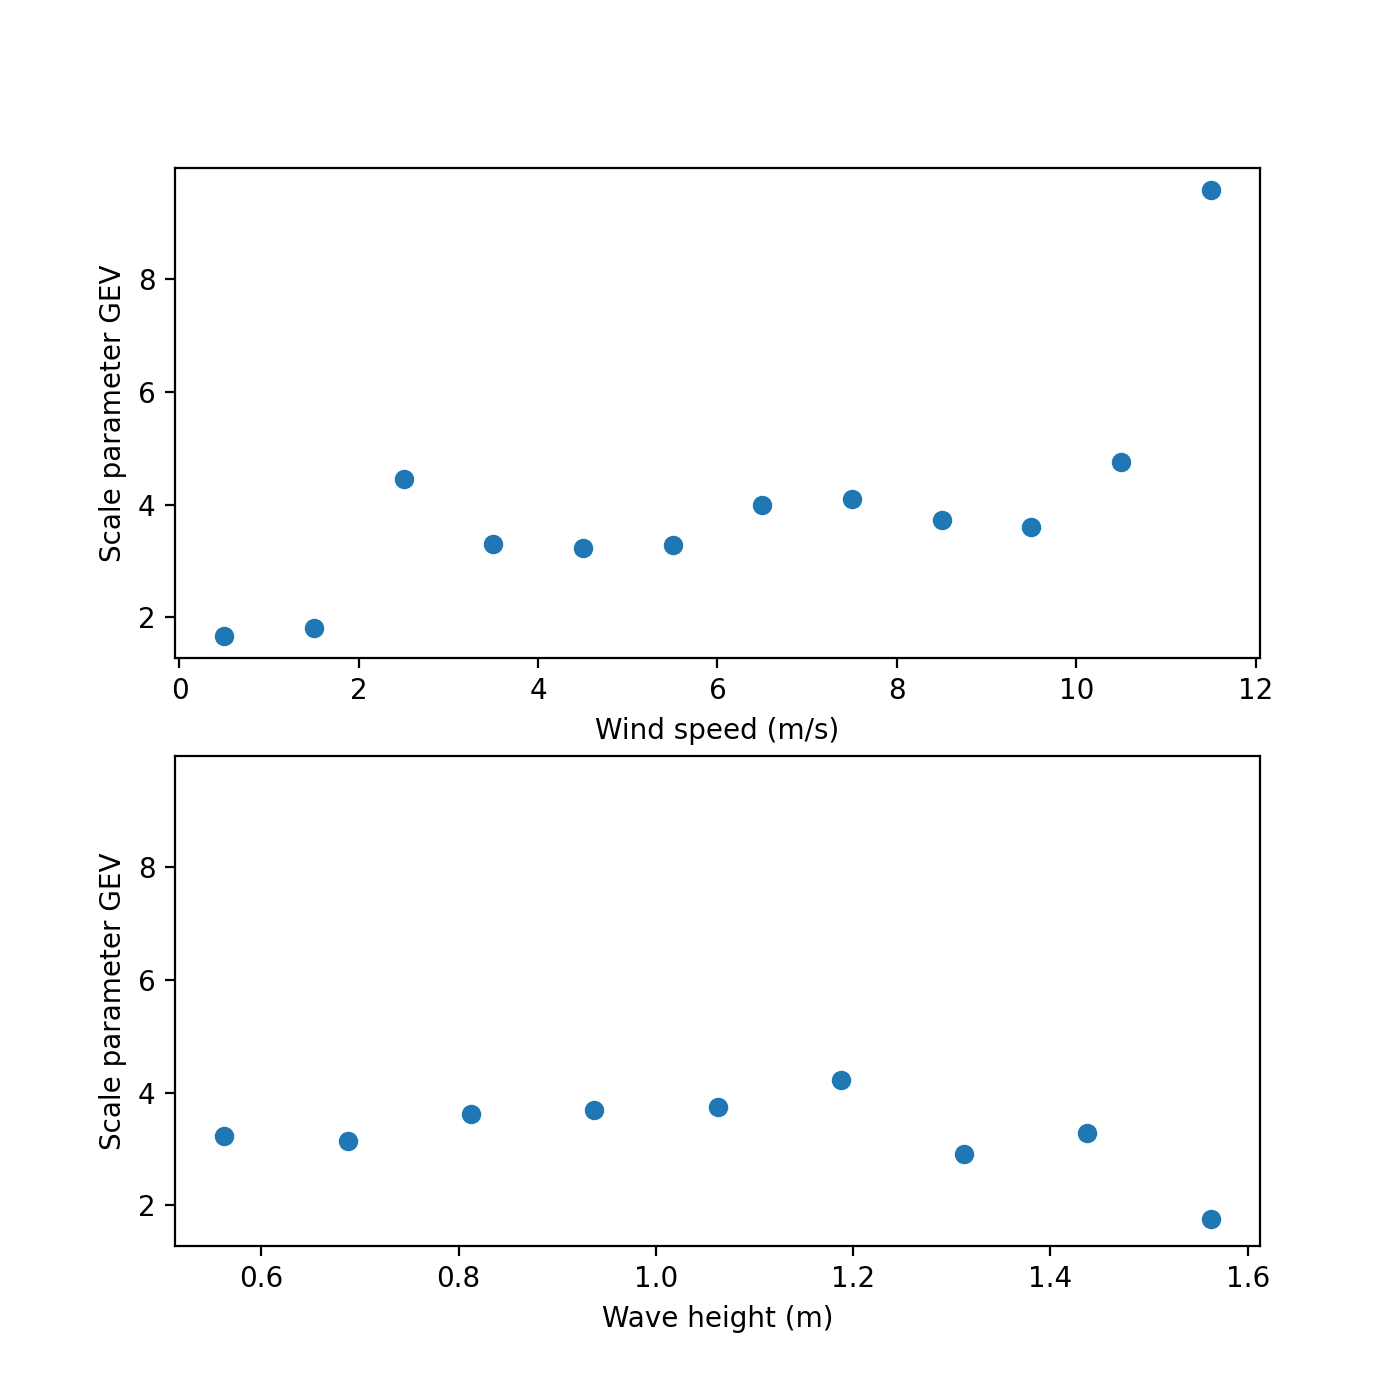

Text(0, 0.5, 'Scale parameter GEV')

In [22]:
fig, (ax1, ax2) = plt.subplots(2, sharey=True, sharex= False, figsize=(7,7))
ax1.scatter(wind_references, parameter_list_tower_V[2])
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Scale parameter GEV')
ax2.scatter(waveH_references, parameter_list_tower_Hs[2])
ax2.set_xlabel('Wave height (m)')
ax2.set_ylabel('Scale parameter GEV')

# Correlation coefficients

In [23]:
# WIND

r_shape_wind = np.corrcoef(parameter_list_tower_V[0], wind_references)
r_location_wind = np.corrcoef(parameter_list_tower_V[1], wind_references)
r_scale_wind = np.corrcoef(parameter_list_tower_V[2], wind_references)
print(r_shape_wind)
print(r_location_wind)
print(r_scale_wind)

[[1.         0.17340823]
 [0.17340823 1.        ]]
[[1.         0.88222199]
 [0.88222199 1.        ]]
[[1.         0.71268318]
 [0.71268318 1.        ]]


In [24]:
# WAVE HEIGHT

r_shape_waveH = np.corrcoef(parameter_list_tower_Hs[0], waveH_references)
r_location_waveH = np.corrcoef(parameter_list_tower_Hs[1], waveH_references)
r_scale_waveH = np.corrcoef(parameter_list_tower_Hs[2], waveH_references)
print(r_shape_waveH)
print(r_location_waveH)
print(r_scale_waveH)

[[ 1.         -0.01560159]
 [-0.01560159  1.        ]]
[[1.         0.84031003]
 [0.84031003 1.        ]]
[[ 1.         -0.41588073]
 [-0.41588073  1.        ]]


# Dependence Functions

In [25]:
# Define dependence functions

def _power3(x, a, b, c):
    return a + b * x ** c
def _linear(x, a, b):
    return x * a + b
def _exp3(x, a, b, c):
    return a + b * np.exp(c * x)


bounds_3p = [(None, None), (None, None), (None, None)]
bounds_2p = [(None, None), (None, None)]
exp_bounds = [(0, None), (0, None), (None, None)]

power3 = DependenceFunction(_power3, bounds_3p, latex="$a + b * x^c$")
linear = DependenceFunction(_linear, latex="$a + b * x$")
exp3 = DependenceFunction(_exp3, bounds=exp_bounds)

In [26]:
#shape_param_fit= linear.fit(wind_references, parameter_list[0])
#print(shape_param_fit)

#linear.fit(wind_references, parameter_list[0])
#print(linear)

### WIND

In [27]:
wind_ref= np.asarray(wind_references)
shape_wind= np.asarray(parameter_list_tower_V[0])
location_wind= np.asarray(parameter_list_tower_V[1])
scale_wind= np.asarray(parameter_list_tower_V[2])

#print(shape_wind)

In [28]:
linear_param_wind1 = fit_function(linear, wind_ref, shape_wind, (1, 1), "lsq", None, None)
linear_param_wind2 = fit_function(linear, wind_ref, location_wind, (1, 1), "lsq", None, None)
linear_param_wind3 = fit_function(linear, wind_ref, scale_wind, (1, 1), "lsq", None, None)
print(linear_param_wind1)
print(linear_param_wind2)
print(linear_param_wind3)

[0.02413338 0.0046308 ]
[0.42106466 9.61953487]
[0.39495517 1.58860429]


<IPython.core.display.Javascript object>


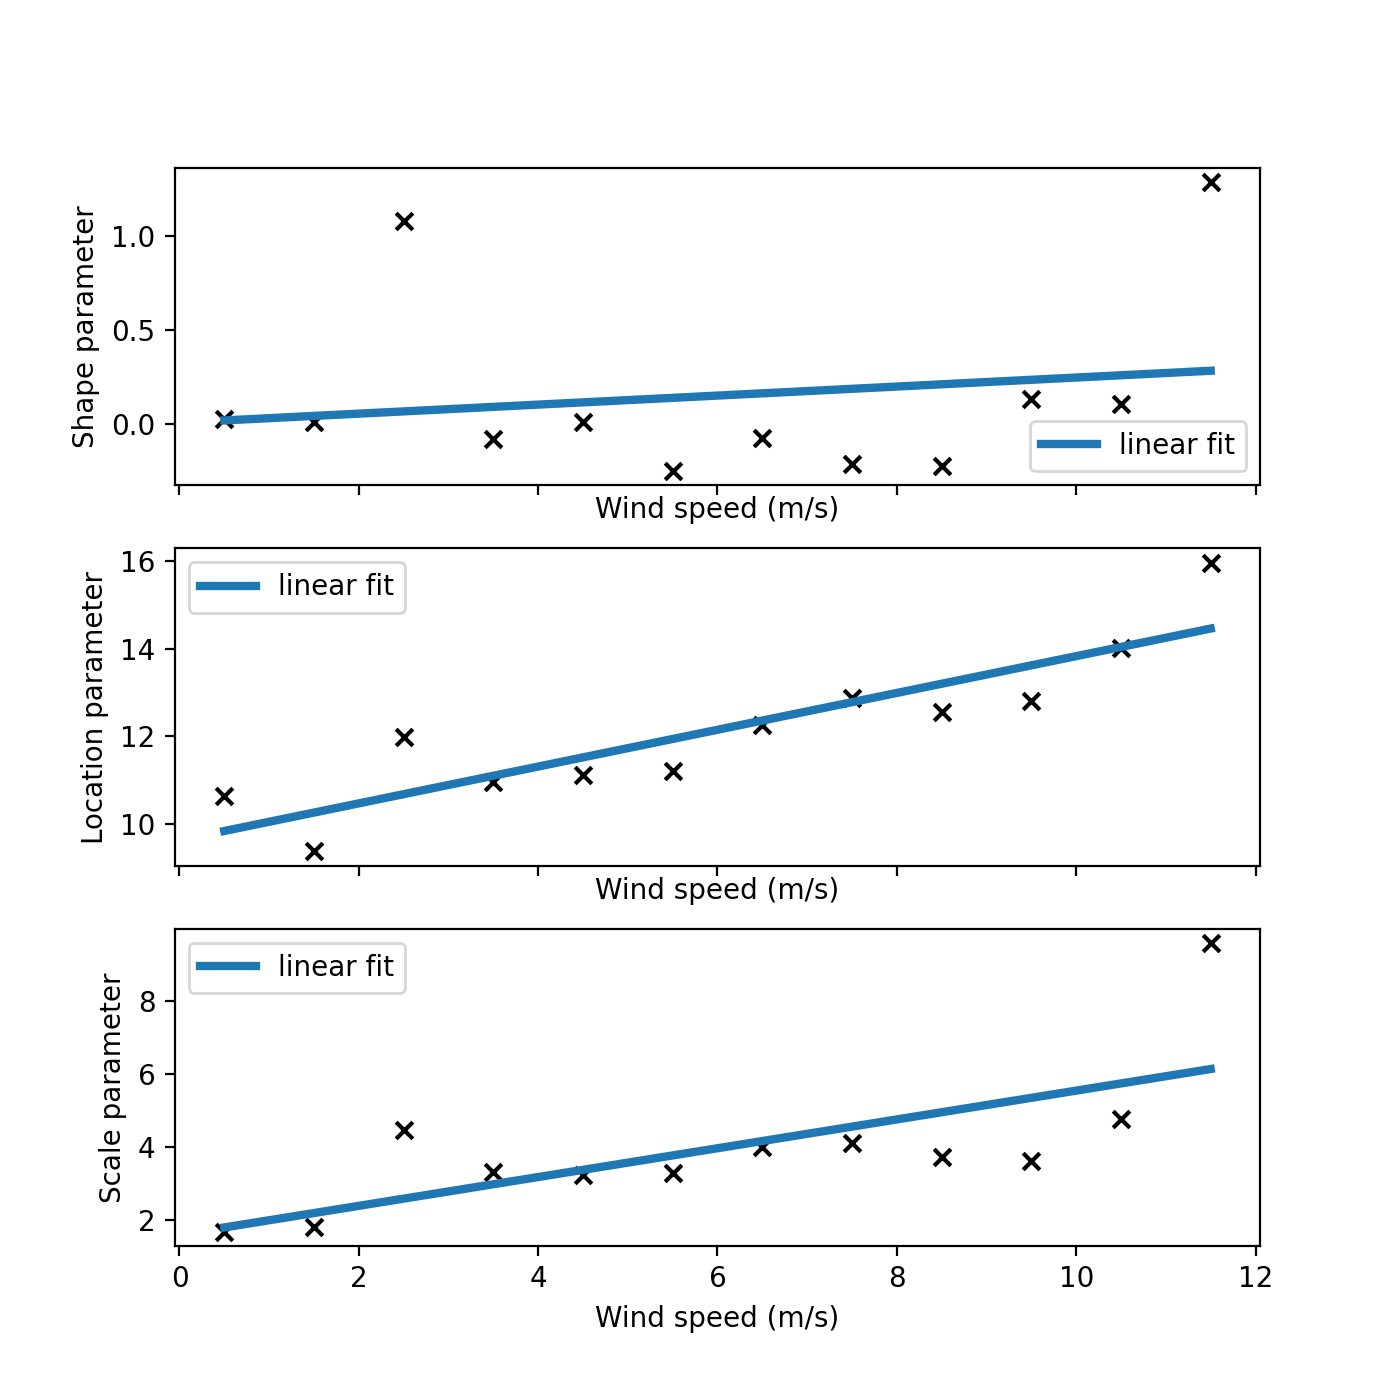

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex= True, figsize=(7,7))
ax1.scatter(wind_ref, shape_wind, marker="x", c="k")
ax1.plot(wind_ref, linear(wind_ref, *linear_param_wind1), label="linear fit", linewidth=3)
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Shape parameter')
ax2.scatter(wind_ref, location_wind, marker="x", c="k")
ax2.plot(wind_ref, linear(wind_ref, *linear_param_wind2), label="linear fit", linewidth=3)
ax2.set_xlabel('Wind speed (m/s)')
ax2.set_ylabel('Location parameter')
ax3.scatter(wind_ref, scale_wind, marker="x", c="k")
ax3.plot(wind_ref, linear(wind_ref, *linear_param_wind3), label="linear fit", linewidth=3)
ax3.set_xlabel('Wind speed (m/s)')
ax3.set_ylabel('Scale parameter')

ax1.legend()
ax2.legend()
ax3.legend()

<IPython.core.display.Javascript object>


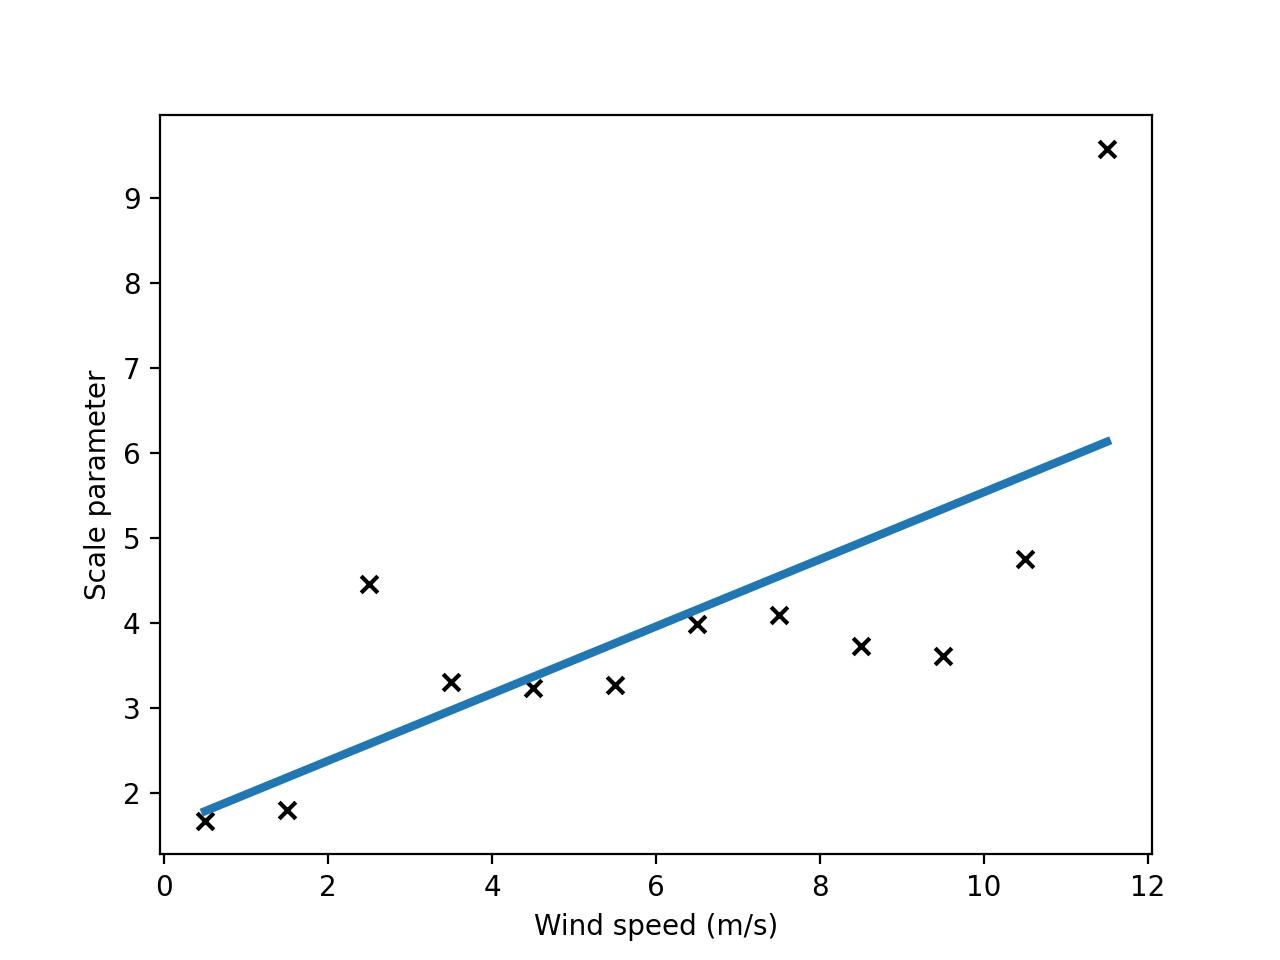

Text(0, 0.5, 'Scale parameter')

In [97]:
plt.figure()
plt.scatter(wind_ref, scale_wind, marker="x", c="k")
plt.plot(wind_ref, linear(wind_ref, *linear_param_wind3), label="linear fit", linewidth=3)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Scale parameter')

### WAVE HEIGHT

In [30]:
waveH_ref= np.asarray(waveH_references)
shape_waveH= np.asarray(parameter_list_tower_Hs[0])
location_waveH= np.asarray(parameter_list_tower_Hs[1])
scale_waveH= np.asarray(parameter_list_tower_Hs[2])

In [31]:
linear_param_waveH1 = fit_function(linear, waveH_ref, shape_waveH, (1, 1), "lsq", None, None)
linear_param_waveH2 = fit_function(linear, waveH_ref, location_waveH, (1, 1), "lsq", None, None)
linear_param_waveH3 = fit_function(linear, waveH_ref, scale_waveH, (1, 1), "lsq", None, None)
print(linear_param_waveH1)
print(linear_param_waveH2)
print(linear_param_waveH3)

[-0.0045892  -0.10119567]
[1.97875058 9.82487112]
[-0.84316748  4.18521024]


<IPython.core.display.Javascript object>


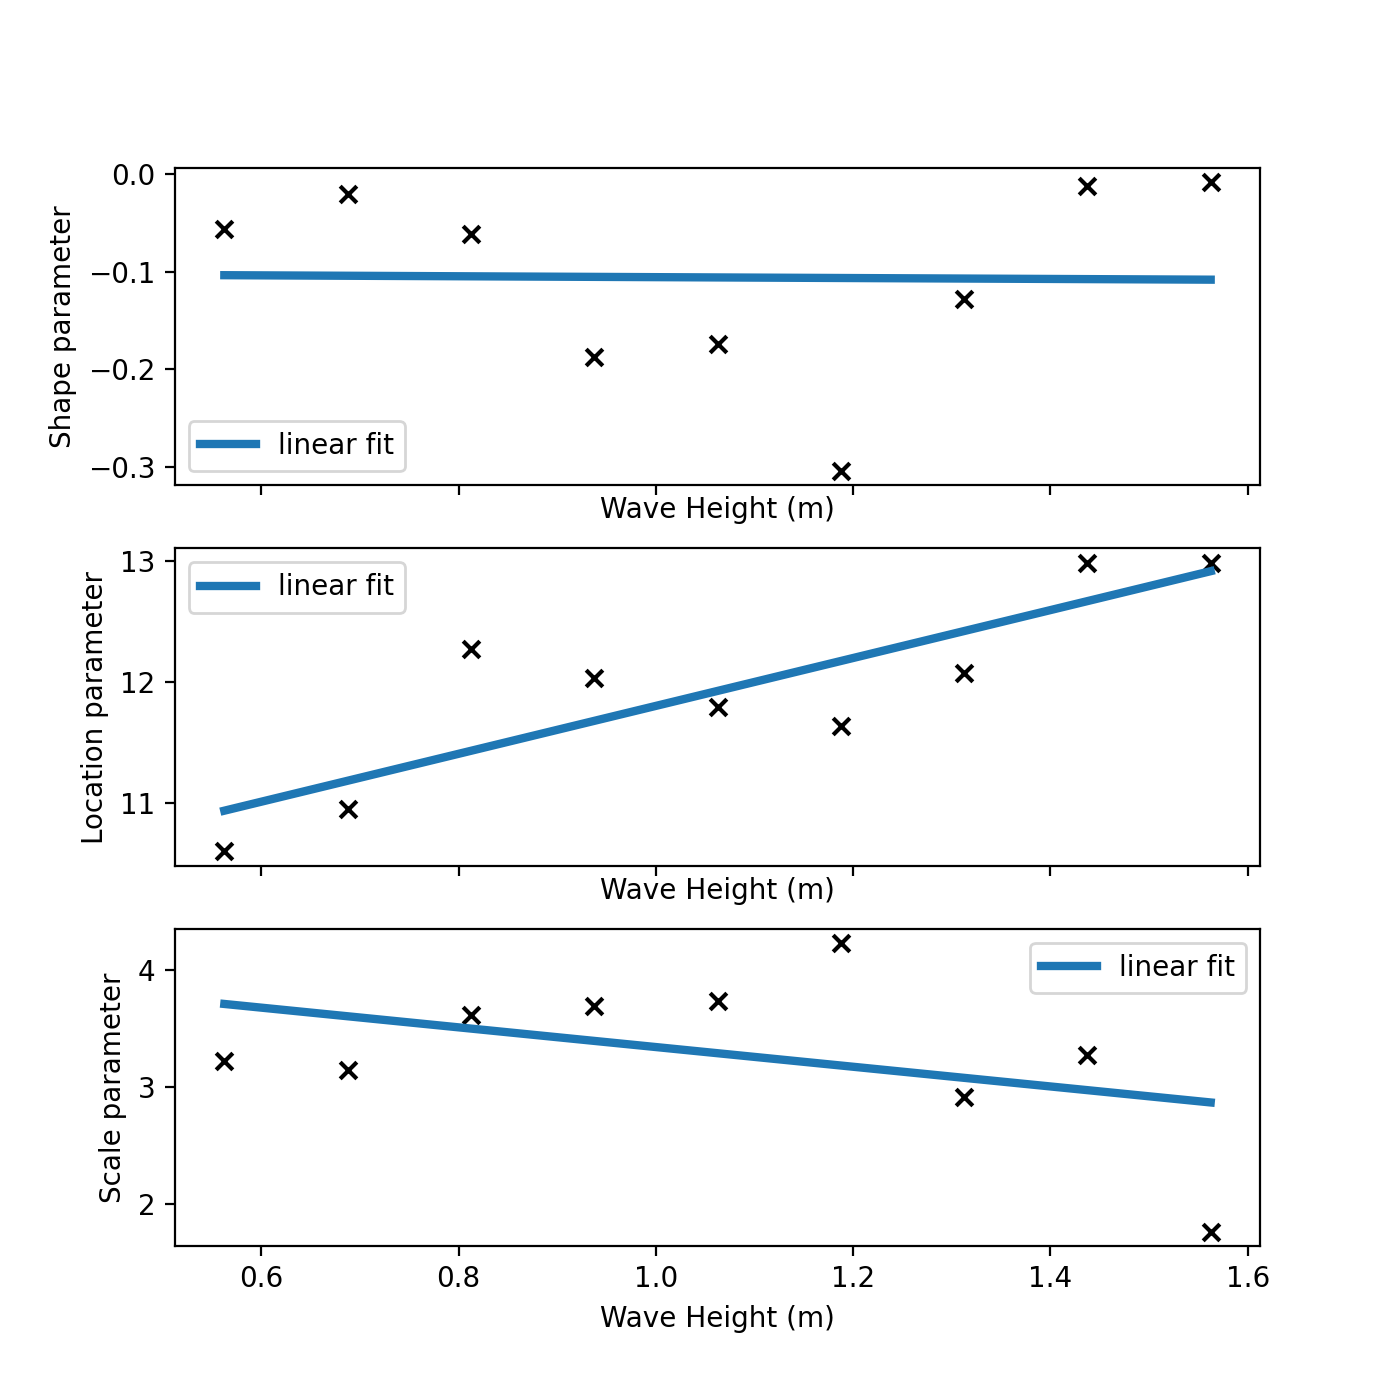

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex= True, figsize=(7,7))
ax1.scatter(waveH_ref, shape_waveH, marker="x", c="k")
ax1.plot(waveH_ref, linear(waveH_ref, *linear_param_waveH1), label="linear fit", linewidth=3)
ax1.set_xlabel('Wave Height (m)')
ax1.set_ylabel('Shape parameter')
ax2.scatter(waveH_ref, location_waveH, marker="x", c="k")
ax2.plot(waveH_ref, linear(waveH_ref, *linear_param_waveH2), label="linear fit", linewidth=3)
ax2.set_xlabel('Wave Height (m)')
ax2.set_ylabel('Location parameter')
ax3.scatter(waveH_ref, scale_waveH, marker="x", c="k")
ax3.plot(waveH_ref, linear(waveH_ref, *linear_param_waveH3), label="linear fit", linewidth=3)
ax3.set_xlabel('Wave Height (m)')
ax3.set_ylabel('Scale parameter')

ax1.legend()
ax2.legend()
ax3.legend()

# Modell 1: R(Hs)

In [33]:
# Average scale and shape 

#average_xi= shape_waveH.mean()
#average_sigma= scale_waveH.mean()
#print(average_xi)
#print(average_sigma)
print(gev_fit_tower[0])
print(gev_fit_tower[2])

-0.1118007401397142
3.496913938662952


In [34]:
def mu_func2D(hs):
    return linear_param_waveH2[0]*hs +linear_param_waveH2[1]
#def sigma_func(hs):
    #return -0.635*hs +4.497

In [35]:
#xi= xi_func(data.waveHeight)
mu2D= mu_func2D(data.waveHeight)
#sigma= sigma_func(data.waveHeight)
print(mu2D)

0      12.575334
1      12.575334
2      12.575334
3      12.575334
4      12.575334
         ...    
795    10.893396
796    10.893396
797    10.893396
798    10.893396
799    10.893396
Name: waveHeight, Length: 800, dtype: float64


In [36]:
con_dist_Hs= stats.genextreme(gev_fit_tower[0], mu2D, gev_fit_tower[2])
#cdf=joint_dist.cdf(r_grid)
#pdf=joint_dist.pdf(r_grid)
#rvs=joint_dist.rvs(size=(20,20))
sample_size= tuple([len(data)])
rvs_2D= con_dist_Hs.rvs(size=sample_size)
print(rvs_2D)

[14.11505712 20.07569417 18.11028509 28.63955577 14.93709265 11.12651819
 15.51222189 10.51064909 16.6133975  25.97554638 17.6031132  10.37848181
 13.21234085 15.3625474  10.98575426 12.81146978 12.21742655 12.84962901
 14.32718628 16.13650673 22.37351702 15.79538981 22.72723038  9.65091491
 13.37654723  9.03456636 11.25053393 11.27169869 18.99213039 28.54372529
 14.91725581 25.58859823 12.91709349  7.35445088 18.71241022 20.68360529
 21.46610347 10.9884532  18.98509958 14.43553433  6.49802773  6.94838118
 12.46934657 10.16318195 13.27134214 16.965267    8.30286054 14.30863945
 12.2507112  14.93573388 17.35215138 13.10326618 14.6067308  14.83522998
 10.83777522 11.5727562  11.62531653 34.80510897 11.83413365 17.74255889
 13.64889534 12.02238584 11.68976916 14.55677079  8.84066622 14.76277599
 12.66481931 14.17562458 19.01678482 10.89567177 14.99164427 12.66064711
  9.94358539 15.20889603 10.99677998 34.50292509 18.33558787  8.65215474
  5.77309484 24.51800714 18.94985049  6.2799451  12

In [37]:
peak_defl_tower= pd.DataFrame.to_numpy(data.peakDeflectionTower)
#print(peak_defl_tower)
model_error= peak_defl_tower-rvs_2D
model_error= abs(model_error)
model_error_mean= model_error.mean()
print(model_error_mean)

5.319698824906095


## Comparison real data and model

<IPython.core.display.Javascript object>


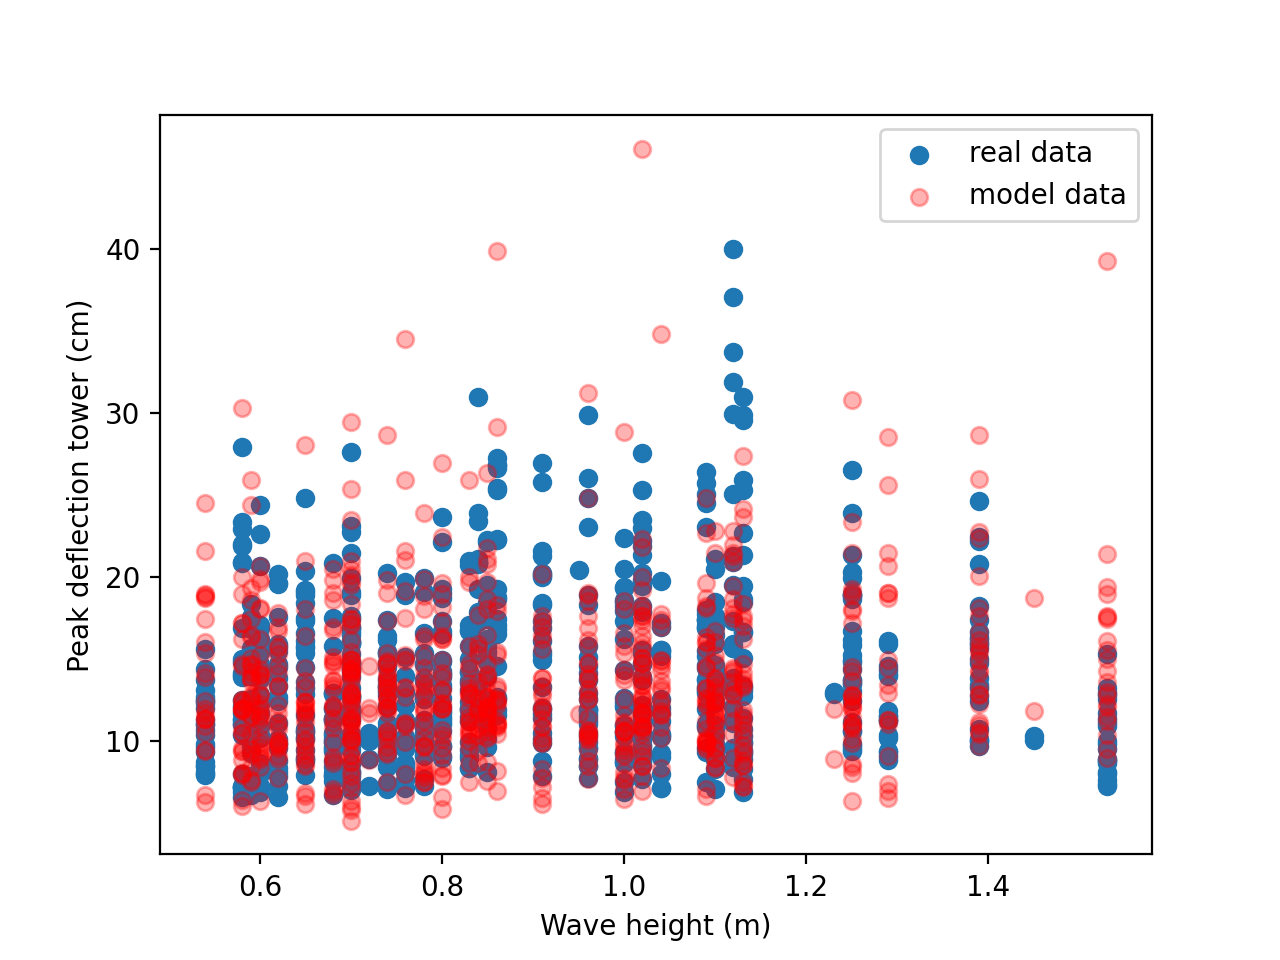

In [38]:
plt.figure()
plt.scatter(data.waveHeight, data.peakDeflectionTower, label='real data')
plt.scatter(data.waveHeight, rvs_2D, alpha=0.3, color= 'r', label='model data')
plt.xlabel('Wave height (m)')
plt.ylabel('Peak deflection tower (cm)')
plt.legend()

## Goddness of fit

In [39]:
#print(data.peakDeflectionTower.mean())
#print(np.mean(rvs_2D))
print(np.quantile(data.peakDeflectionTower, 0.1))
print(np.quantile(rvs_2D, 0.1))
print(data.peakDeflectionTower.median())
print(np.median(rvs_2D))
print(np.quantile(data.peakDeflectionTower, 0.9))
print(np.quantile(rvs_2D, 0.9))
print(np.quantile(data.peakDeflectionTower, 0.99))
print(np.quantile(rvs_2D, 0.99))

8.630849999999999
8.592679235051829
12.77685
12.57133898297202
20.73686
19.350856200686987
29.875719999999998
29.47532679336293


<IPython.core.display.Javascript object>


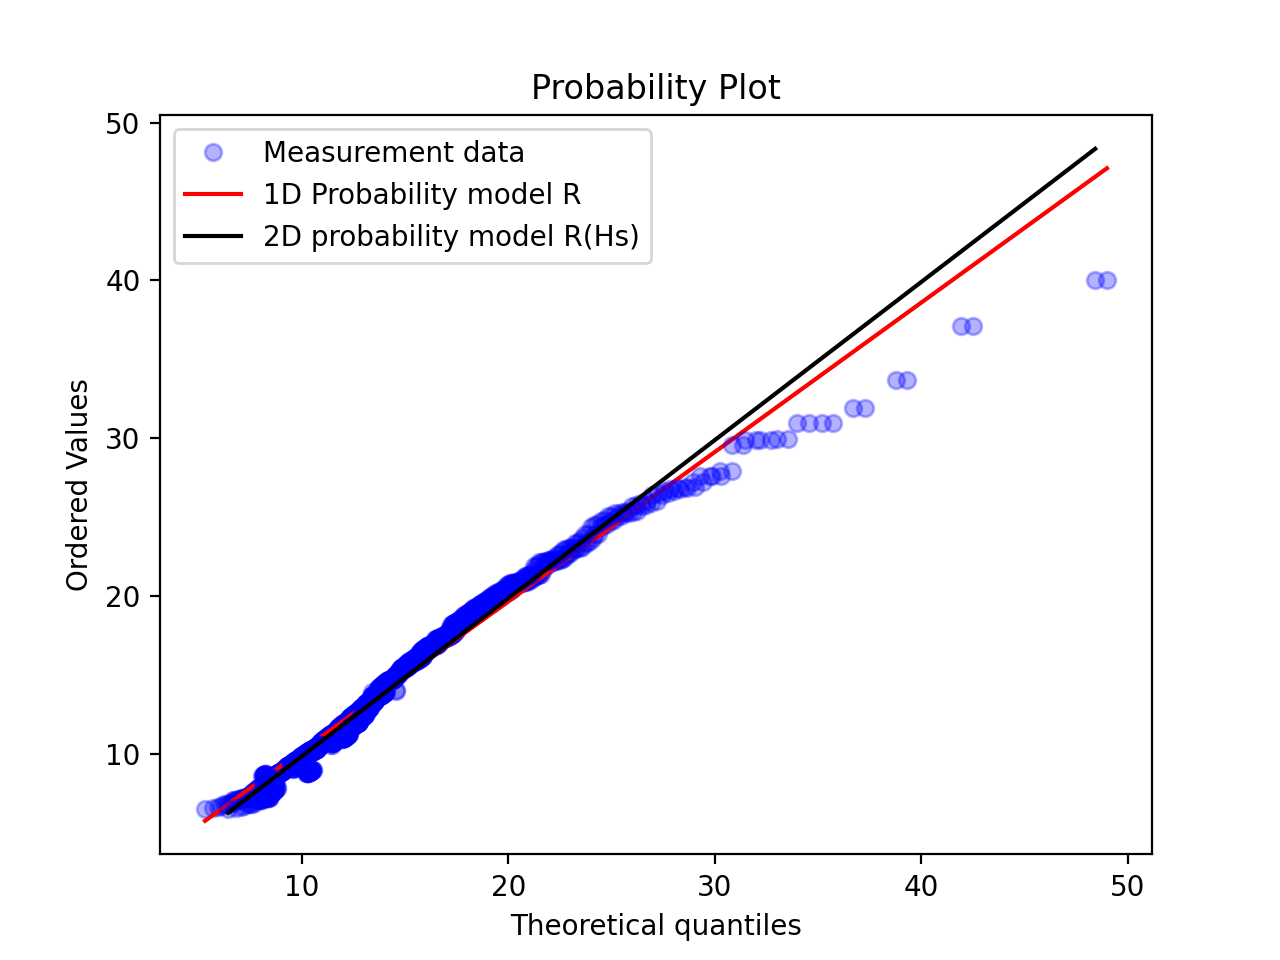

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(data.peakDeflectionTower, (gev_fit_tower[0], gev_fit_tower[1], gev_fit_tower[2]), dist='genextreme', plot=ax)
stats.probplot(data.peakDeflectionTower, (gev_fit_tower[0], mu2D, gev_fit_tower[2]), dist='genextreme', plot=ax)
#ax.set_title("Probability plot of sample data against the quantiles of a specified theoretical distribution.")

ax.get_lines()[0].set_markerfacecolor('b')
ax.get_lines()[0].set_alpha(0.3)
ax.get_lines()[2].set_alpha(0.3)
ax.get_lines()[3].set_color('black')
ax.get_lines()[0].set_label('Measurement data')
ax.get_lines()[1].set_label('1D Probability model R')
ax.get_lines()[3].set_label('2D probability model R(Hs)')

ax.legend()
plt.show()

# Modell 2: R(Hs,V)

Idee: 
- shape, location und scale parameter auf ein zweidimensionales Koordinatensystem aus hs und v intervallen fitten
- dann basierend auf den Intervallen eine gemeinsame Abhängigkeit (Ebene) fitten

<IPython.core.display.Javascript object>


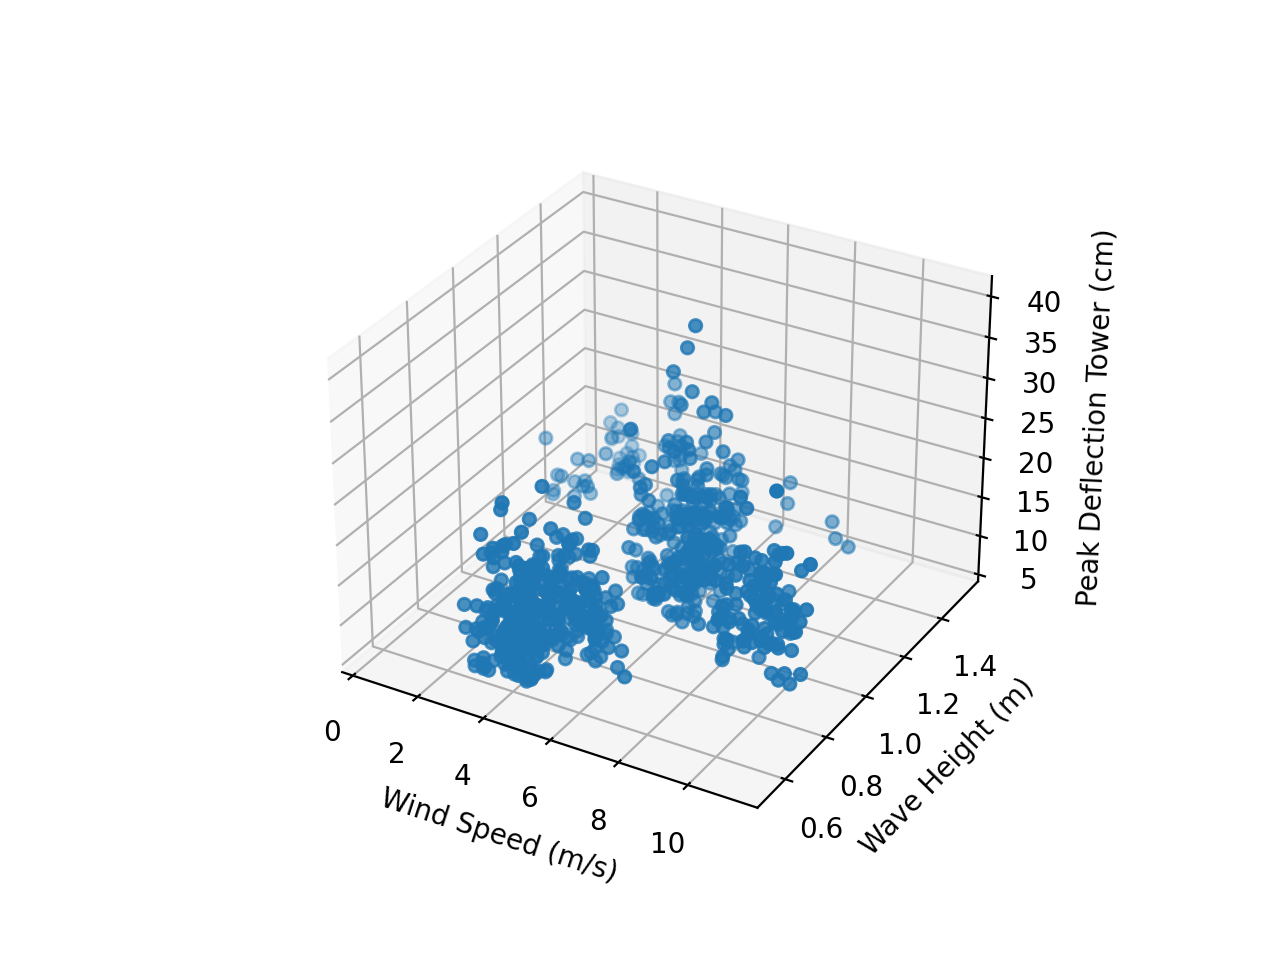

Text(0.5, 0, 'Peak Deflection Tower (cm)')

In [41]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = data.windSpeed
ys = data.waveHeight
zs = data.peakDeflectionTower
ax.scatter(xs, ys, zs)
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Wave Height (m)')
ax.set_zlabel('Peak Deflection Tower (cm)')

In [42]:
width_slicer_V2 = WidthOfIntervalSlicer(width=2.5, reference="right", min_n_points=1)
width_slicer_Hs2 = WidthOfIntervalSlicer(width=0.5, reference="right", min_n_points=1)

wind_slices2, wind_references2, wind_boundaries2 = width_slicer_V2.slice_(data.windSpeed)
waveH_slices2, waveH_references2, waveH_boundaries2 = width_slicer_Hs2.slice_(data.waveHeight)

print(wind_boundaries2)
print(waveH_boundaries2)
print(type(len(wind_boundaries2)))

[(1.25, 3.75), (3.75, 6.25), (6.25, 8.75), (8.75, 11.25)]
[(0.25, 0.75), (0.75, 1.25), (1.25, 1.75)]
<class 'int'>


In [43]:
# This for loop does the following:
# 1. Find peak deflection data that are simultaneously in a certain interval of both hs and v 
# 2. Estimate the parameters of the GEV distribution of that specific interval
# 3. Sort the parameters into matrices of shape, scale and location parameter

shape_matrix = np.empty((len(wind_boundaries2), len(waveH_boundaries2)))
shape_matrix[:] = np.NaN

scale_matrix = np.empty((len(wind_boundaries2), len(waveH_boundaries2)))
scale_matrix[:] = np.NaN

location_matrix = np.empty((len(wind_boundaries2), len(waveH_boundaries2)))
location_matrix[:] = np.NaN


for j in range (len(wind_references2)):
    for k in range (len(waveH_references2)):
        data_storage= []
        for i in range(len(data)):
            if ((data.windSpeed[i] >= wind_boundaries2[j][0]) & (data.windSpeed[i] < wind_boundaries2[j][1]) & (data.waveHeight[i] >= waveH_boundaries2[k][0]) & (data.waveHeight[i] < waveH_boundaries2[k][1]) ):
                data_storage.append(data.peakDeflectionTower[i])

        if len(data_storage)== 0:
            data_storage.append(data.peakDeflectionTower[i])
            data_storage.append(data.peakDeflectionTower[i])

        #print(data_storage)
        #print(len(data_storage))
        fit= stats.genextreme.fit(data_storage)
        #print(fit[1])
        shape_matrix[j][k]= fit[0]
        scale_matrix[j][k]= fit[2]
        location_matrix[j][k]= fit[1]

/Applications/anaconda3/envs/env_masterthese/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:406: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
/Applications/anaconda3/envs/env_masterthese/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


In [44]:
print(shape_matrix)
print(scale_matrix)
print(location_matrix)

[[-0.01849123  1.44030391 -0.15493112]
 [-0.02753626 -0.23744305 -0.06657141]
 [-4.19768138 -0.06122741  0.41397807]
 [-0.86590519  0.01377364  1.57386679]]
[[3.50921987e+00 5.52189899e-02 2.16659402e+00]
 [3.14515208e+00 3.35689094e+00 3.41632970e+00]
 [1.90779424e-09 4.20943999e+00 3.51867154e+00]
 [3.46503970e-23 3.86810142e+00 3.24349991e-01]]
[[10.8639239  12.94066157  9.98729822]
 [10.84024517 11.30594935 12.9109327 ]
 [ 7.9825     12.51457852 14.62424583]
 [ 8.4496     12.92921168 10.49921522]]


In [45]:
# This for loop writes the values of the shape, scale and location parameter into vectors with the corresponding
# wave height and wind speed. 

shape_vector= []
scale_vector= []
location_vector= []

for i in range(len(wind_boundaries2)):
    for j in range(len(waveH_boundaries2)):
        for k in range(len(wind_boundaries2)*len(waveH_boundaries2)):
            shape_storage= []
            scale_storage= []
            location_storage= []
            shape_storage.append([shape_matrix[i][j],wind_references2[i], waveH_references2[j]])
            scale_storage.append([scale_matrix[i][j],wind_references2[i], waveH_references2[j]])
            location_storage.append([location_matrix[i][j],wind_references2[i], waveH_references2[j]])
        shape_vector.append(shape_storage)
        scale_vector.append(scale_storage)
        location_vector.append(location_storage)

#print(shape_vector)
#print(shape_vector[0])

In [46]:
# This loop brings the vectors above in a matrix of R|Hs|V 

shape_data = np.empty((len(shape_vector),3))
shape_data[:] = np.NaN

scale_data = np.empty((len(scale_vector),3))
scale_data[:] = np.NaN

location_data = np.empty((len(location_vector),3))
location_data[:] = np.NaN

k=0
for i in range(len(wind_boundaries2)):
    for j in range(len(waveH_boundaries2)):
        shape_data[k][0]= shape_matrix[i][j]
        shape_data[k][1]= waveH_references2[j]
        shape_data[k][2]= wind_references2[i]
        
        scale_data[k][0]= scale_matrix[i][j]
        scale_data[k][1]= waveH_references2[j]
        scale_data[k][2]= wind_references2[i]
        
        location_data[k][0]= location_matrix[i][j]
        location_data[k][1]= waveH_references2[j]
        location_data[k][2]= wind_references2[i]
        k=k+1

In [47]:
#print(shape_data)
#print(scale_data)
#print(type(shape_data[1][1]))
#print(type(location_data[1][1]))
#print(location_data)

## Modell Shape Parameter

In [48]:
X,Y = np.meshgrid(np.arange(0, 2, 0.5), np.arange(0, 10, 0.5))
XX = X.flatten()
YY = Y.flatten()

# best-fit linear plane
A = np.c_[shape_data[:,1], shape_data[:,2], np.ones(shape_data.shape[0])]
C_shape,_,_,_ = scipy.linalg.lstsq(A, shape_data[:,0])    # coefficients
print(C_shape)

# evaluate it on grid
Z = C_shape[0]*X + C_shape[1]*Y + C_shape[2]

[ 1.7189891  -0.06865092 -1.47224291]


<IPython.core.display.Javascript object>


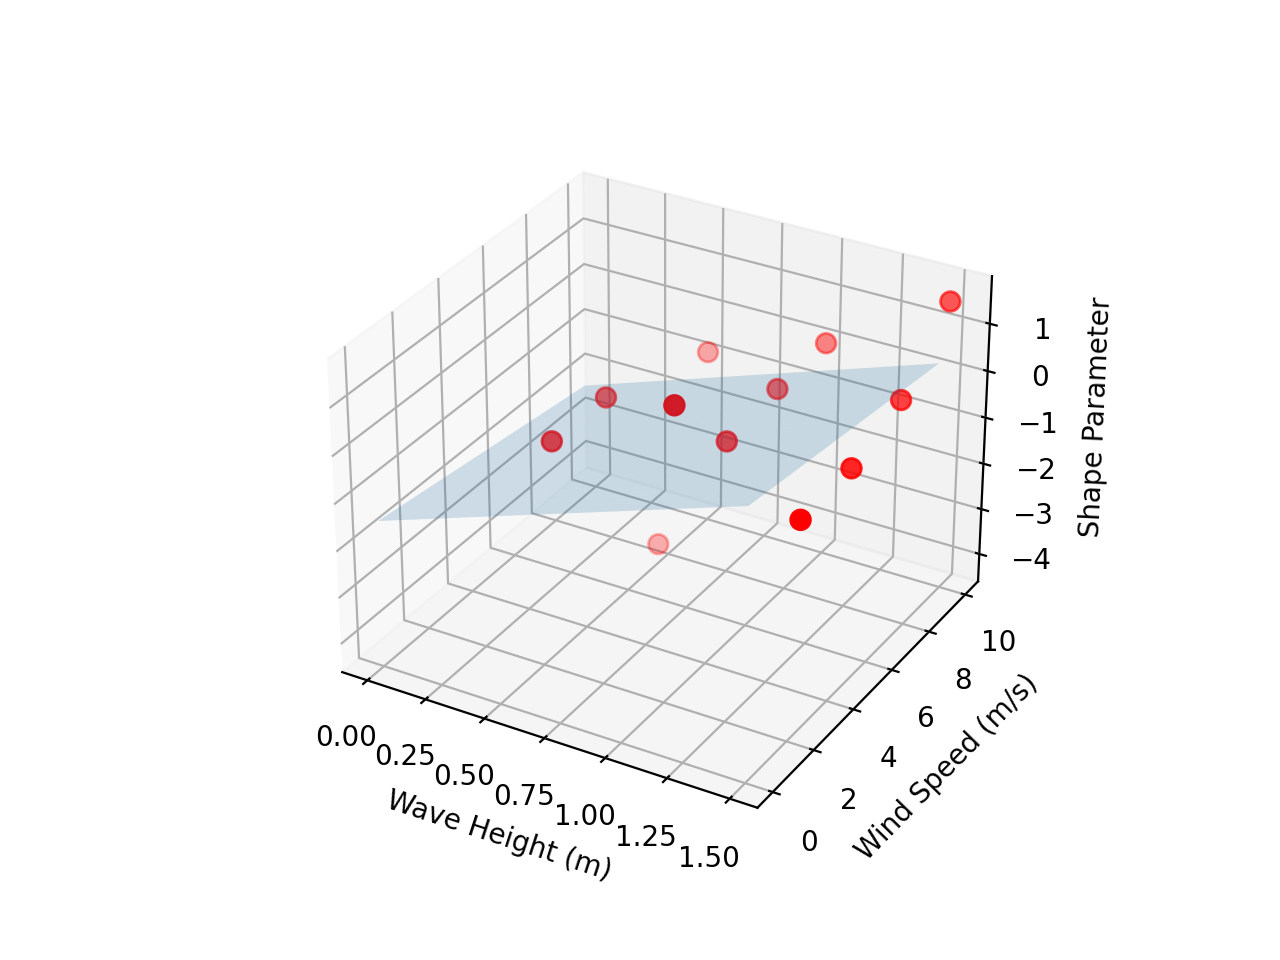

In [49]:
# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(shape_data[:,1], shape_data[:,2], shape_data[:,0], c='r', s=50)
plt.xlabel('Wave Height (m)')
plt.ylabel('Wind Speed (m/s)')
ax.set_zlabel('Shape Parameter')
ax.axis('auto')
ax.axis('tight')
plt.show()

## Modell Scale Parameter

In [50]:
X,Y = np.meshgrid(np.arange(0, 2, 0.5), np.arange(0, 10, 0.5))
XX = X.flatten()
YY = Y.flatten()

# best-fit linear plane
A = np.c_[scale_data[:,1], scale_data[:,2], np.ones(scale_data.shape[0])]
C_scale,_,_,_ = scipy.linalg.lstsq(A, scale_data[:,0])    # coefficients
print(C_scale)

# evaluate it on grid
Z = C_scale[0]*X + C_scale[1]*Y + C_scale[2]

[ 0.69289332 -0.09074674  2.17177119]


<IPython.core.display.Javascript object>


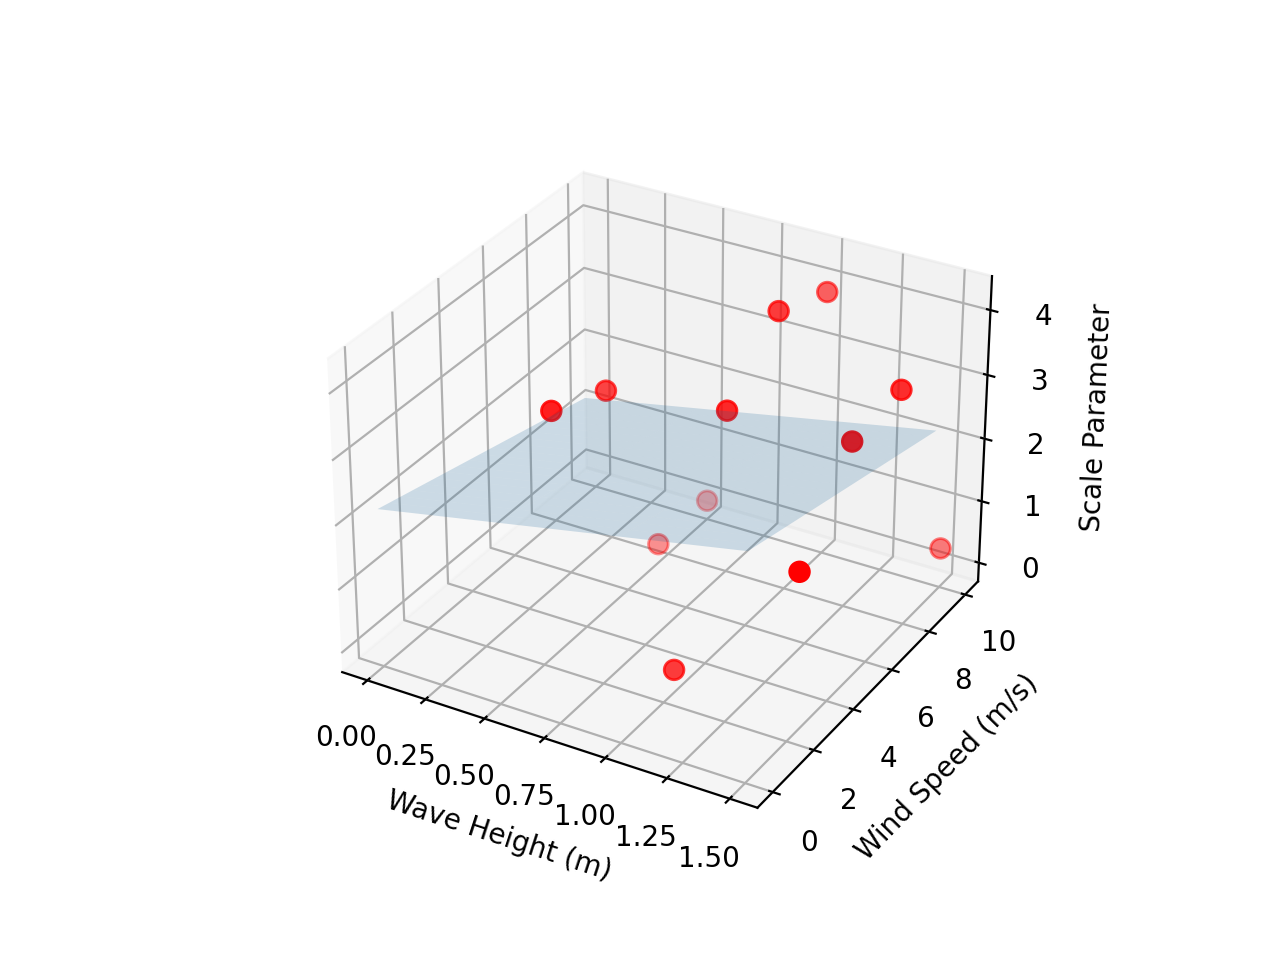

In [51]:
# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(scale_data[:,1], scale_data[:,2], scale_data[:,0], c='r', s=50)
plt.xlabel('Wave Height (m)')
plt.ylabel('Wind Speed (m/s)')
ax.set_zlabel('Scale Parameter')
ax.axis('auto')
ax.axis('tight')
plt.show()

## Modell Location Parameter

In [52]:
X,Y = np.meshgrid(np.arange(0, 2, 0.5), np.arange(0, 10, 0.5))
#XX = X.flatten()
#YY = Y.flatten()

# best-fit linear plane
A = np.c_[location_data[:,1], location_data[:,2], np.ones(location_data.shape[0])]
#A = np.c_[location_data[:,1], location_data[:,2], np.linspace(0, 8, 12)]
#A = np.c_[location_data[:,1], np.ones(location_data.shape[0])]
C_loc,_,_,_ = scipy.linalg.lstsq(A, location_data[:,0])    # coefficients
print(C_loc)
#print(A)

# evaluate it on grid
Z = C_loc[0]*X + C_loc[1]*Y + C_loc[2]
#Z = C_loc[0]*X  + C_loc[1]

[ 2.47135572 -0.07569831  9.32245556]


In [53]:
#def function(data, a, b, c):
    #x = data[0]
    #y = data[1]
    
    #return a*x + b*y + c

#parameters, covariance = curve_fit(function, [location_data[:,2],location_data[:,1] ], location_data[:,0])

# create surface function model
# setup data points for calculating surface model
#X,Y = np.meshgrid(np.arange(0, 2, 0.5), np.arange(0, 10, 0.5))
# calculate Z coordinate array
#Z = function(np.array([X, Y]), *parameters)
#print(parameters)

<IPython.core.display.Javascript object>


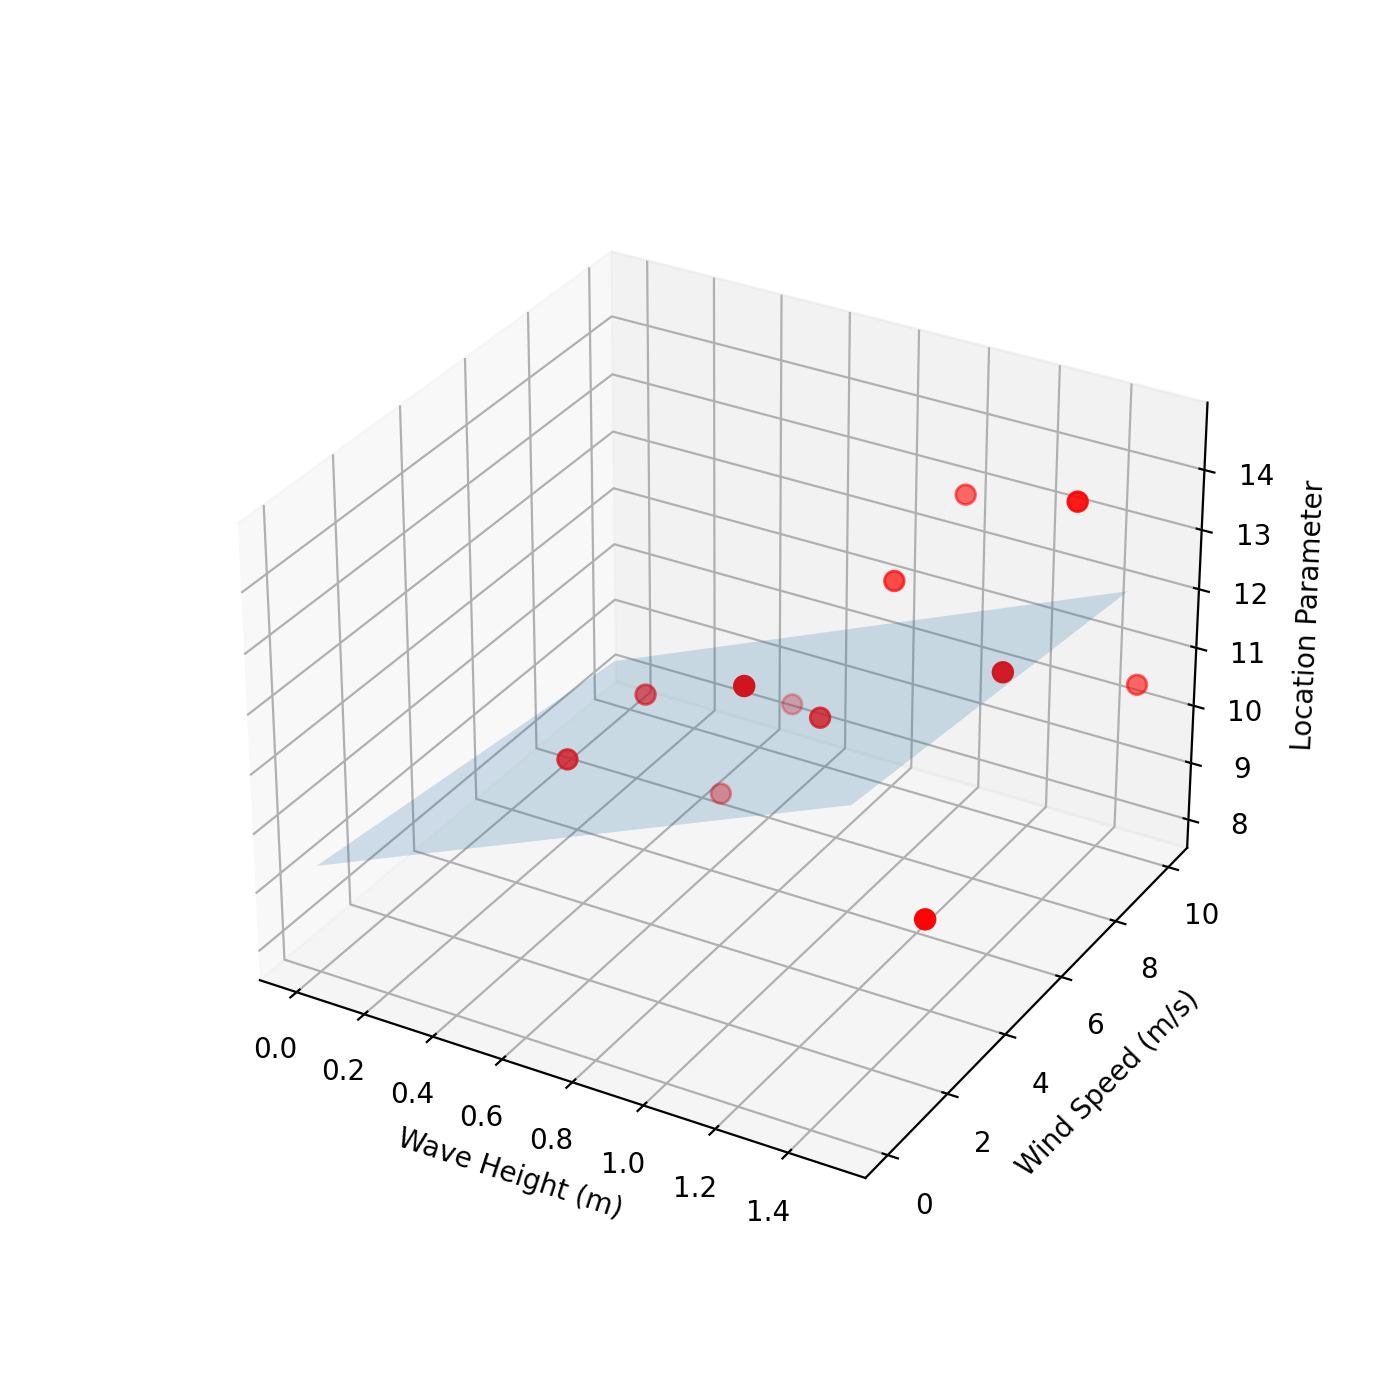

In [93]:
# plot points and fitted surface
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(location_data[:,1], location_data[:,2], location_data[:,0], c='r', s=50)
plt.xlabel('Wave Height (m)')
plt.ylabel('Wind Speed (m/s)')
ax.set_zlabel('Location Parameter')
ax.axis('auto')
ax.axis('tight')
plt.show()

# Modell 2 R(Hs,V)

In [55]:
def mu_func3D(hs, v):
    return C_loc[0]*hs +C_loc[1]*v +C_loc[2]
    #return C_loc[0]*hs +0*v +C_loc[1]
#def sigma_func3D(hs, v):
    #return C_scale[0]*hs +C_scale[1]*v +C_scale[2]
def sigma_func_2D_wind(v):
    return 0.39495517*v + 1.58860429

In [56]:
mu3D= mu_func3D(data.waveHeight, data.windSpeed)
#sigma3D= sigma_func3D(data.waveHeight, data.windSpeed)
sigma2D= sigma_func_2D_wind(data.windSpeed)

In [57]:
con_dist_HsV= stats.genextreme(gev_fit_tower[0], mu3D, sigma2D)
print(con_dist_HsV)
rvs_3D= con_dist_HsV.rvs(size=800)
print(gev_fit_tower[0])
print(gev_fit_tower[1])
print(gev_fit_tower[2])

-0.1118007401397142
11.45977029288046
3.496913938662952


<IPython.core.display.Javascript object>


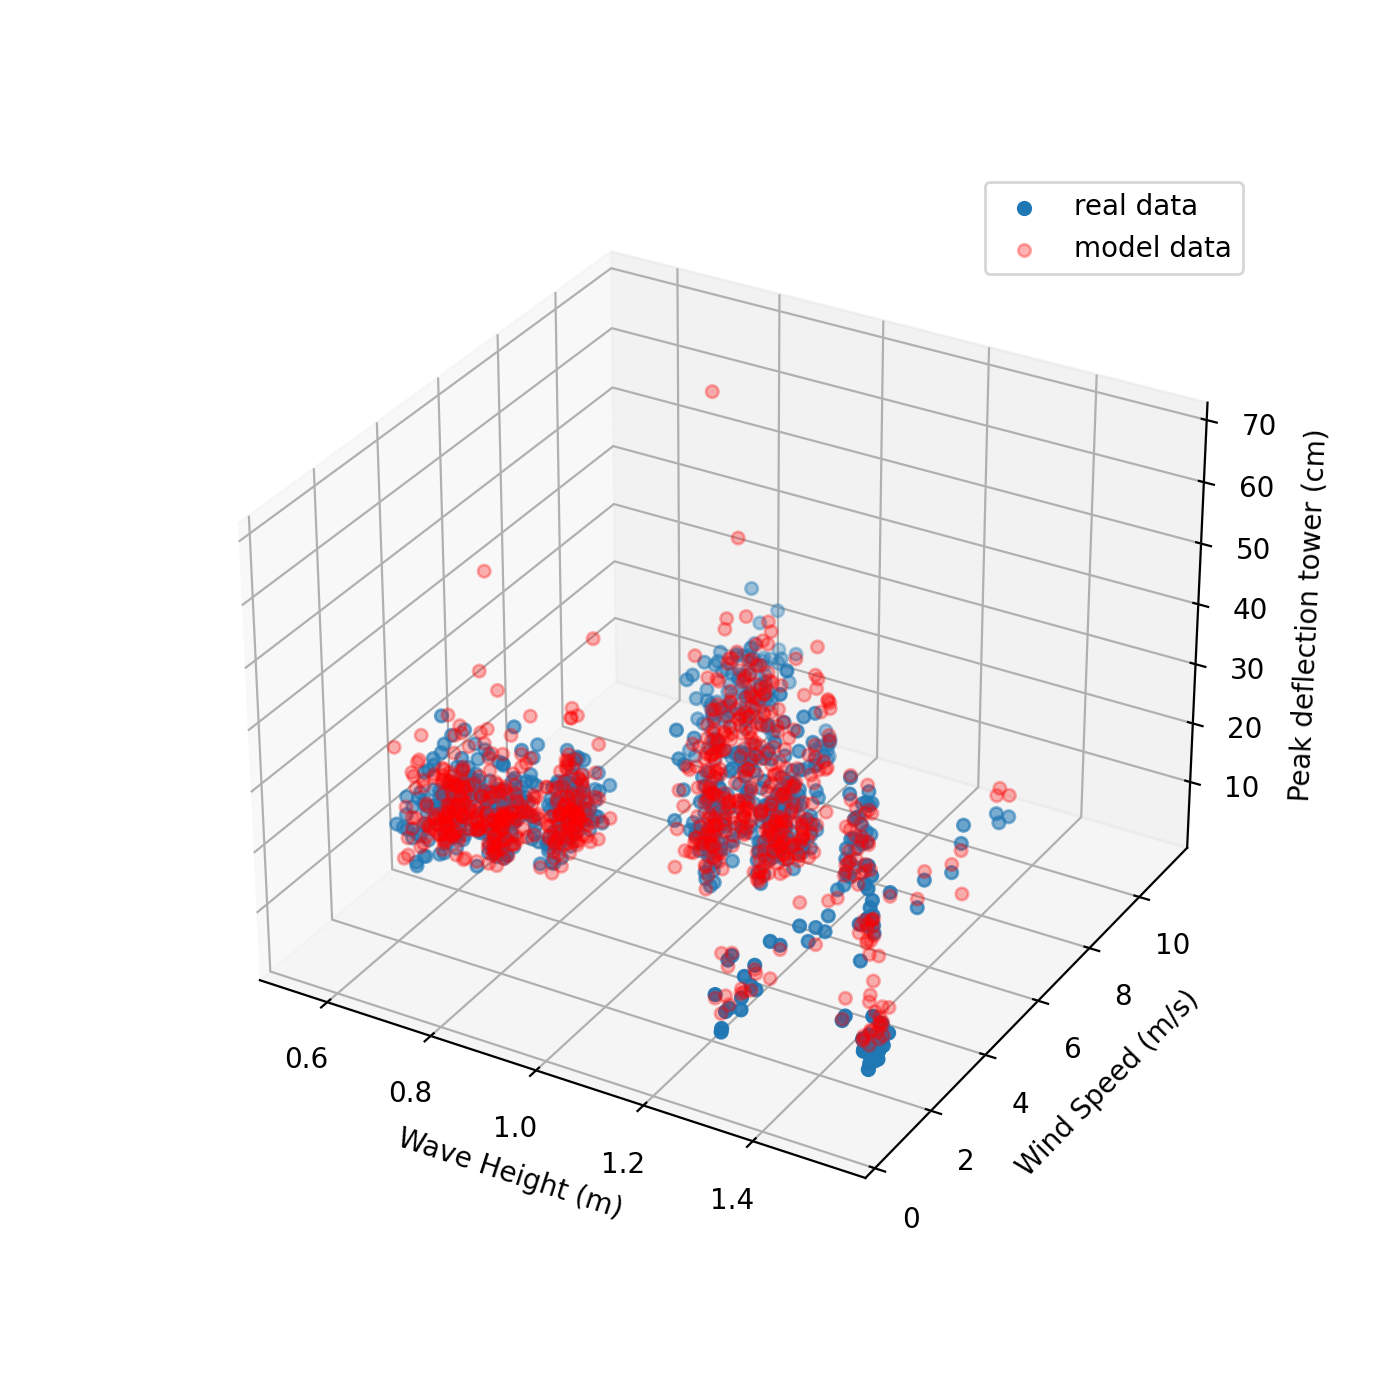

In [89]:
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
ax.scatter(data.waveHeight, data.windSpeed, data.peakDeflectionTower, label='real data')
ax.scatter(data.waveHeight, data.windSpeed, rvs_3D, alpha=0.3, color= 'r', label='model data')
plt.xlabel('Wave Height (m)')
plt.ylabel('Wind Speed (m/s)')
ax.set_zlabel('Peak deflection tower (cm)')
ax.axis('auto')
ax.axis('tight')
plt.legend()
plt.show()

## Goodness of fit

In [59]:
#print(data.peakDeflectionTower.mean())
#print(np.mean(rvs_3D))

print(np.quantile(data.peakDeflectionTower, 0.1))
print(np.quantile(rvs_3D, 0.1))

print(data.peakDeflectionTower.median())
print(np.median(rvs_3D))

print(np.quantile(data.peakDeflectionTower, 0.9))
print(np.quantile(rvs_3D, 0.9))

print(np.quantile(data.peakDeflectionTower, 0.99))
print(np.quantile(rvs_3D, 0.99))

8.630849999999999
7.853713736934411
12.77685
12.548701415213092
20.73686
20.6883804718072
29.875719999999998
30.155756201423593


## Quantile Plots

In [60]:
intervals_Hs_2Dmodel= []
for i in range (len(waveH_references)):
    intervals_Hs_2Dmodel.append([])


for i in range(len(waveH_slices)):
    for j in range(len(waveH_slices[i])):
        if (data.waveHeight[j] >= waveH_boundaries[i][0]) & (data.waveHeight[j] < waveH_boundaries[i][1]):
            intervals_Hs_2Dmodel[i].append(rvs_2D[j])

intervals_Hs_3Dmodel= []
for i in range (len(waveH_references)):
    intervals_Hs_3Dmodel.append([])
    
for i in range(len(waveH_slices)):
    for j in range(len(waveH_slices[i])):
        if (data.waveHeight[j] >= waveH_boundaries[i][0]) & (data.waveHeight[j] < waveH_boundaries[i][1]):
            intervals_Hs_3Dmodel[i].append(rvs_3D[j])

In [61]:
# discrete quantiles of the models 

quantile10_data= []
quantile50_data= []
quantile90_data= []
quantile99_data= []

quantile10_model2D= []
quantile50_model2D= []
quantile90_model2D= []
quantile99_model2D= []

quantile10_model3D= []
quantile50_model3D= []
quantile90_model3D= []
quantile99_model3D= []

for i in range (len(tower_defl_intervals_Hs)):
    quantile10_data.append(np.quantile(tower_defl_intervals_Hs[i], 0.10))
    quantile50_data.append(np.quantile(tower_defl_intervals_Hs[i], 0.50))
    quantile90_data.append(np.quantile(tower_defl_intervals_Hs[i], 0.90))
    quantile99_data.append(np.quantile(tower_defl_intervals_Hs[i], 0.99))
    
for i in range (len(intervals_Hs_2Dmodel)):
    quantile10_model2D.append(np.quantile(intervals_Hs_2Dmodel[i], 0.10))
    quantile50_model2D.append(np.quantile(intervals_Hs_2Dmodel[i], 0.50))
    quantile90_model2D.append(np.quantile(intervals_Hs_2Dmodel[i], 0.90))
    quantile99_model2D.append(np.quantile(intervals_Hs_2Dmodel[i], 0.99))
    
for i in range (len(intervals_Hs_3Dmodel)):
    quantile10_model3D.append(np.quantile(intervals_Hs_3Dmodel[i], 0.10))
    quantile50_model3D.append(np.quantile(intervals_Hs_3Dmodel[i], 0.50))
    quantile90_model3D.append(np.quantile(intervals_Hs_3Dmodel[i], 0.90))
    quantile99_model3D.append(np.quantile(intervals_Hs_3Dmodel[i], 0.99))

In [62]:
print(quantile99_model3D)

[31.95536739969977, 26.89750685746745, 39.51409182995738, 26.789246457498333, 29.97610553708739, 34.738800935126406, 27.930544461828763, 25.17463619837814, 23.601940120773396]


In [92]:
# 2D quantiles continuous
quantiles2D_10= con_dist_Hs.ppf(0.1)
quantiles2D_50= con_dist_Hs.ppf(0.5)
quantiles2D_90= con_dist_Hs.ppf(0.9)

# 3D quantiles contiunous 
quantiles3D_10= con_dist_HsV.ppf(0.1)
quantiles3D_50= con_dist_HsV.ppf(0.5)
quantiles3D_90= con_dist_HsV.ppf(0.9)

<IPython.core.display.Javascript object>


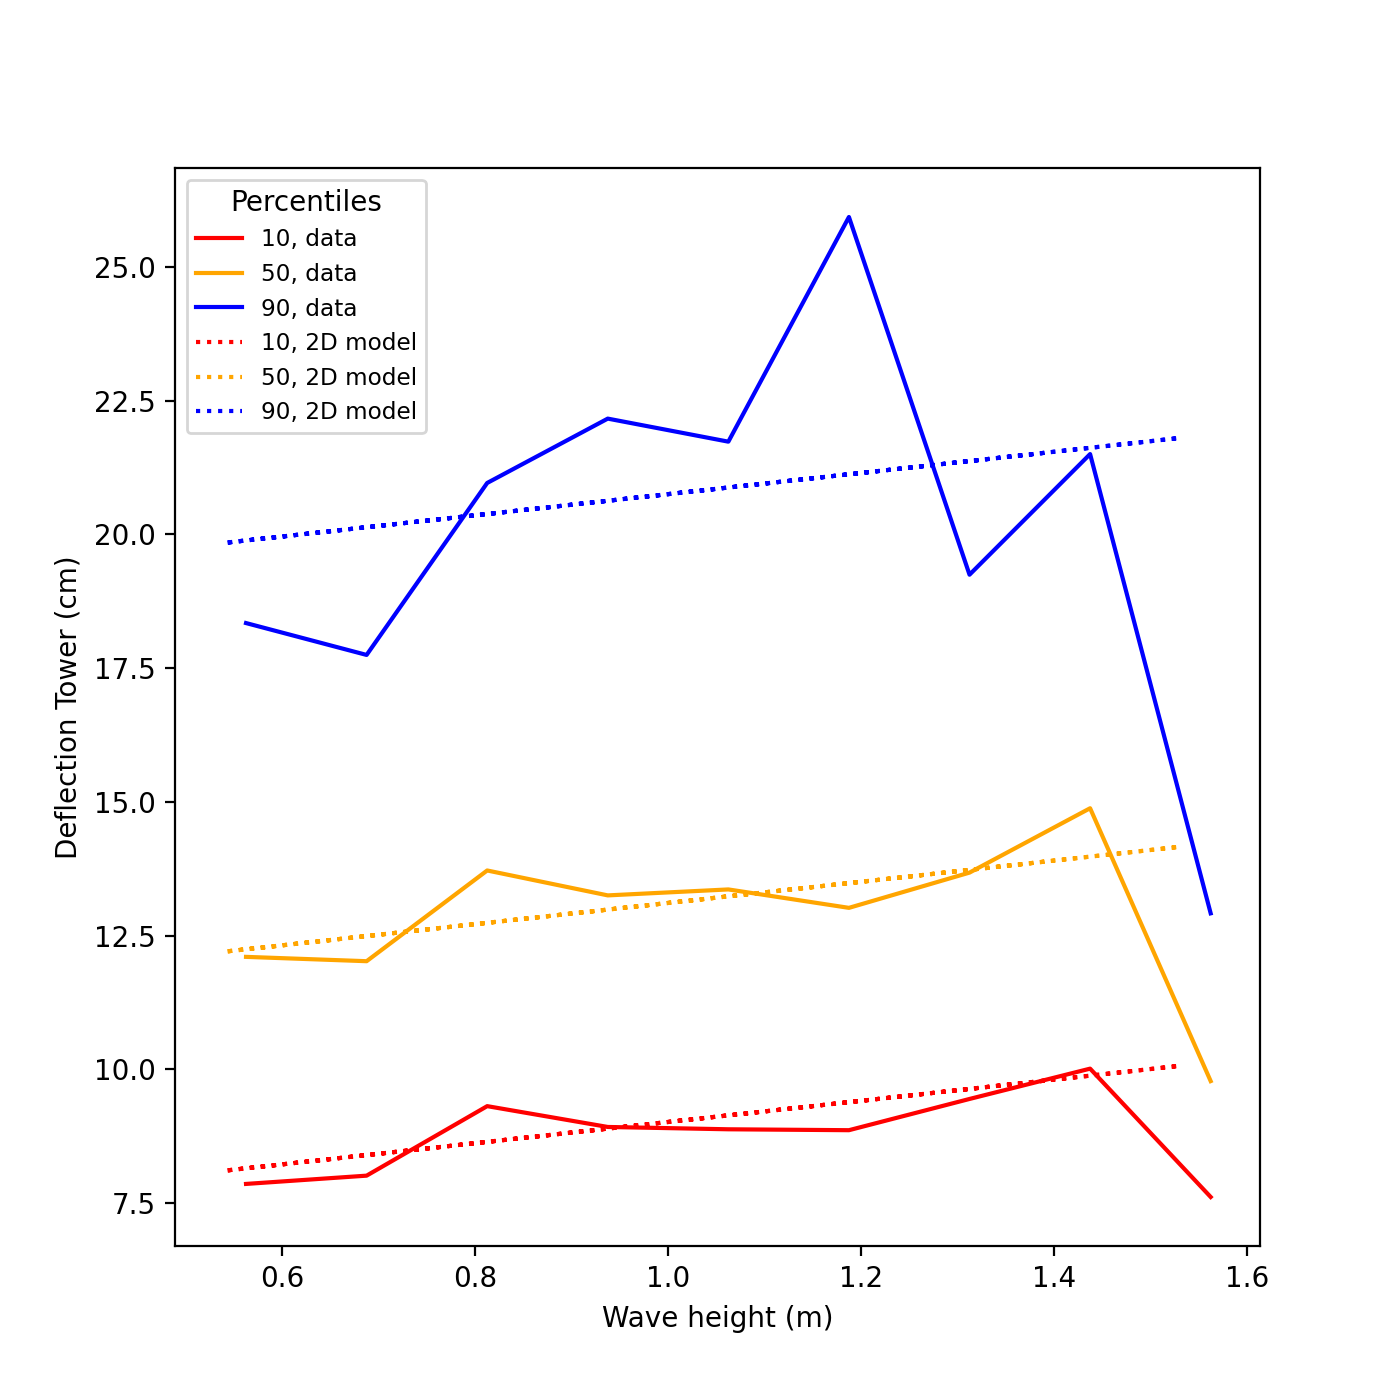

In [91]:
plt.figure(figsize=(7,7))
#plt.scatter(data.waveHeight, data.peakDeflectionTower, color= 'k', alpha= 0.3)

plt.plot(waveH_references, quantile10_data, color='r', label='10, data')
plt.plot(waveH_references, quantile50_data, color='orange', label='50, data')
plt.plot(waveH_references, quantile90_data, color='b', label='90, data')
#plt.plot(waveH_references, quantile99_data, color='green', label='99, data')


plt.plot(data.waveHeight, quantiles2D_10, color='r', linestyle=':', label='10, 2D model')
plt.plot(data.waveHeight, quantiles2D_50, color='orange', linestyle=':', label='50, 2D model')
plt.plot(data.waveHeight, quantiles2D_90, color='b', linestyle=':', label='90, 2D model')


#plt.plot(data.waveHeight, quantiles3D_10, color='r', linestyle= '--', label='10, 3D model')
#plt.plot(data.waveHeight, quantiles3D_50, color='orange', linestyle='--', label='50, 3D model')
#plt.plot(data.waveHeight, quantiles3D_90, color='b', linestyle='--', label='90, 3D model')


#plt.plot(waveH_references, quantile10_model3D, color='r', label='10, 3D model', linestyle='--')
#plt.plot(waveH_references, quantile50_model3D, color='orange', label='50, 3D model', linestyle='--')
#plt.plot(waveH_references, quantile90_model3D, color='b', label='90, 3D model', linestyle='--')
#plt.plot(waveH_references, quantile99_model3D, color='green', label='99, 3D model', linestyle='--')

plt.xlabel('Wave height (m)')
plt.ylabel('Deflection Tower (cm)')
plt.legend(title='Percentiles', loc=2, fontsize='small', fancybox=True)

<IPython.core.display.Javascript object>


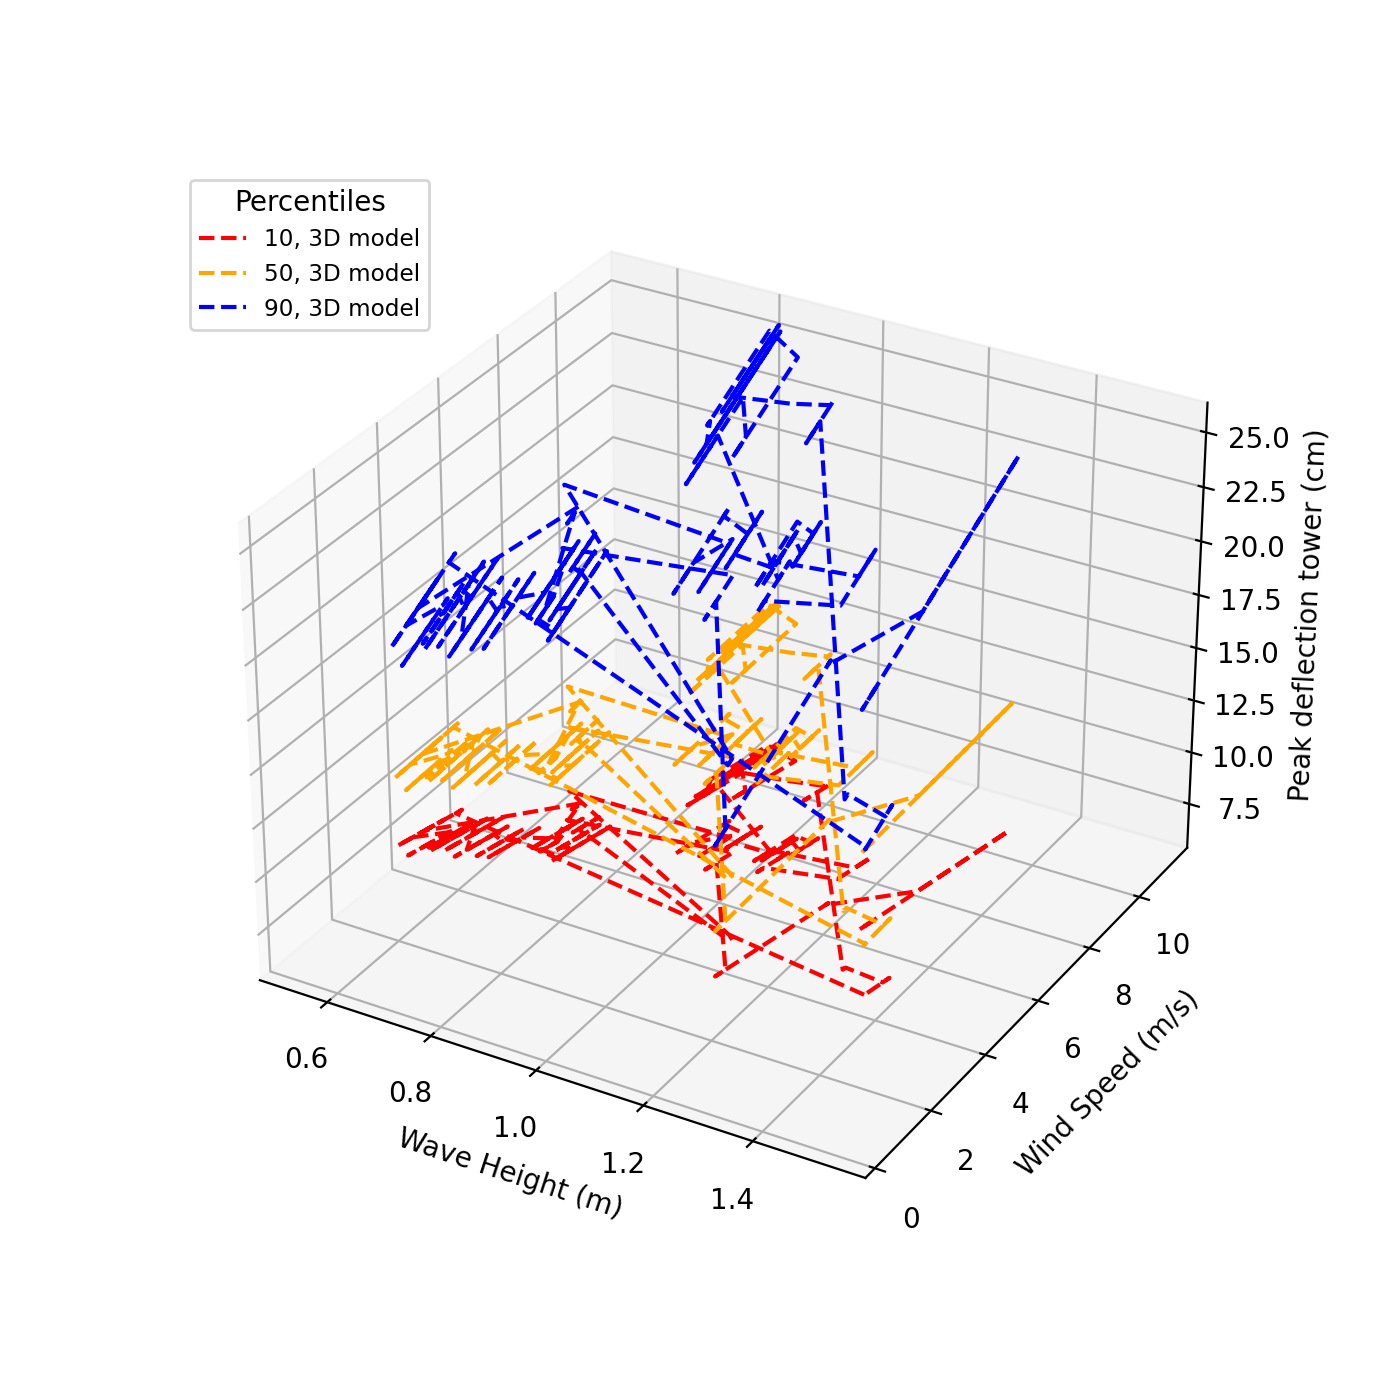

In [99]:
fig = plt.figure(figsize=(7,7))

ax = fig.gca(projection='3d')

#ax.plot(waveH_references, quantile10_data, color='r', label='10, data')
#ax.plot(waveH_references, quantile50_data, color='orange', label='50, data')
#ax.plot(waveH_references, quantile90_data, color='b', label='90, data')

#ax.plot(data.waveHeight, quantiles2D_10, label='10, 2D model', color='r', linestyle=':')
#ax.plot(data.waveHeight, quantiles2D_50, label='50, 2D model',color='orange', linestyle=':')
#ax.plot(data.waveHeight, quantiles2D_90, label='90, 2D model',color='b', linestyle=':')

ax.plot(data.waveHeight, data.windSpeed, quantiles3D_10, label='10, 3D model', color='r', linestyle= '--')
ax.plot(data.waveHeight, data.windSpeed, quantiles3D_50, label='50, 3D model', color='orange', linestyle='--')
ax.plot(data.waveHeight, data.windSpeed, quantiles3D_90, label='90, 3D model', color='b', linestyle='--' )

plt.xlabel('Wave Height (m)')
plt.ylabel('Wind Speed (m/s)')
ax.set_zlabel('Peak deflection tower (cm)')
ax.axis('auto')
ax.axis('tight')
ax.legend(title='Percentiles', loc=2, fontsize='small', fancybox=True)
plt.show()

In [68]:
#error_2D= []
#error_3D= []

#for i in range(len(quantile10_data)):
    #error10= quantile10_data[i]-quantile10_model2D[i]
    #error50= quantile50_data[i]-quantile50_model2D[i]
    #error90= quantile90_data[i]-quantile90_model2D[i]
    #error99= quantile99_data[i]-quantile99_model2D[i]

    #error_2D.append(error10)
    #error_2D.append(error50)
    #error_2D.append(error90)
    #error_2D.append(error99)
    
#for i in range(len(quantile10_data)):
    #error10= quantile10_data[i]-quantile10_model3D[i]
    #error50= quantile50_data[i]-quantile50_model3D[i]
    #error90= quantile90_data[i]-quantile90_model3D[i]
    #error99= quantile99_data[i]-quantile99_model3D[i]

    #error_3D.append(error10)
    #error_3D.append(error50)
    #error_3D.append(error90)
    #error_3D.append(error99)

## Model error

In [69]:
error_2D= []
error_3D= []

for i in range(len(data.peakDeflectionSBIT)):
    error_2D.append(abs(data.peakDeflectionSBIT[i]-rvs_2D[i]))
    
for i in range(len(data.peakDeflectionSBIT)):
    error_3D.append(abs(data.peakDeflectionSBIT[i]-rvs_3D[i]))

In [70]:
norm_fit_error2D= stats.norm.fit(error_2D)
norm_pdf_error2D= stats.norm.pdf(bin_centers, loc= norm_fit_error2D[0], scale= norm_fit_error2D[1])

norm_fit_error3D= stats.norm.fit(error_3D)
norm_pdf_error3D= stats.norm.pdf(bin_centers, loc= norm_fit_error3D[0], scale= norm_fit_error3D[1])

<IPython.core.display.Javascript object>


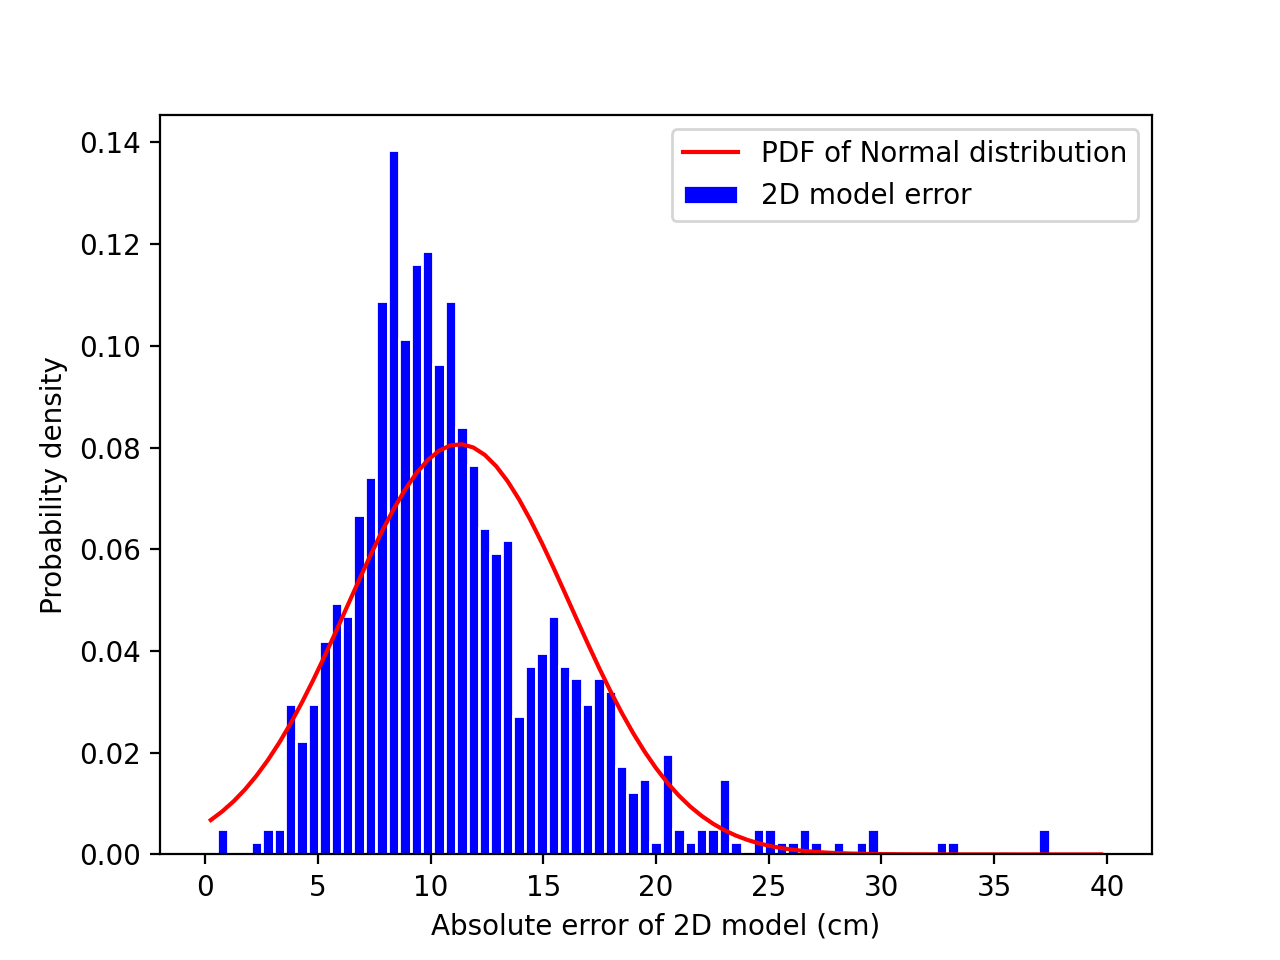

In [71]:
fig, ax1 = plt.subplots()

ax1.hist(error_2D, bins=bins, label='2D model error', color='b', density= 'true', stacked='true', edgecolor='w')
ax1.plot(bin_centers, norm_pdf_error2D, label="PDF of Normal distribution", color='r')
ax1.set_xlabel('Absolute error of 2D model (cm)')
ax1.set_ylabel('Probability density')

ax1.legend()

plt.show()

<IPython.core.display.Javascript object>


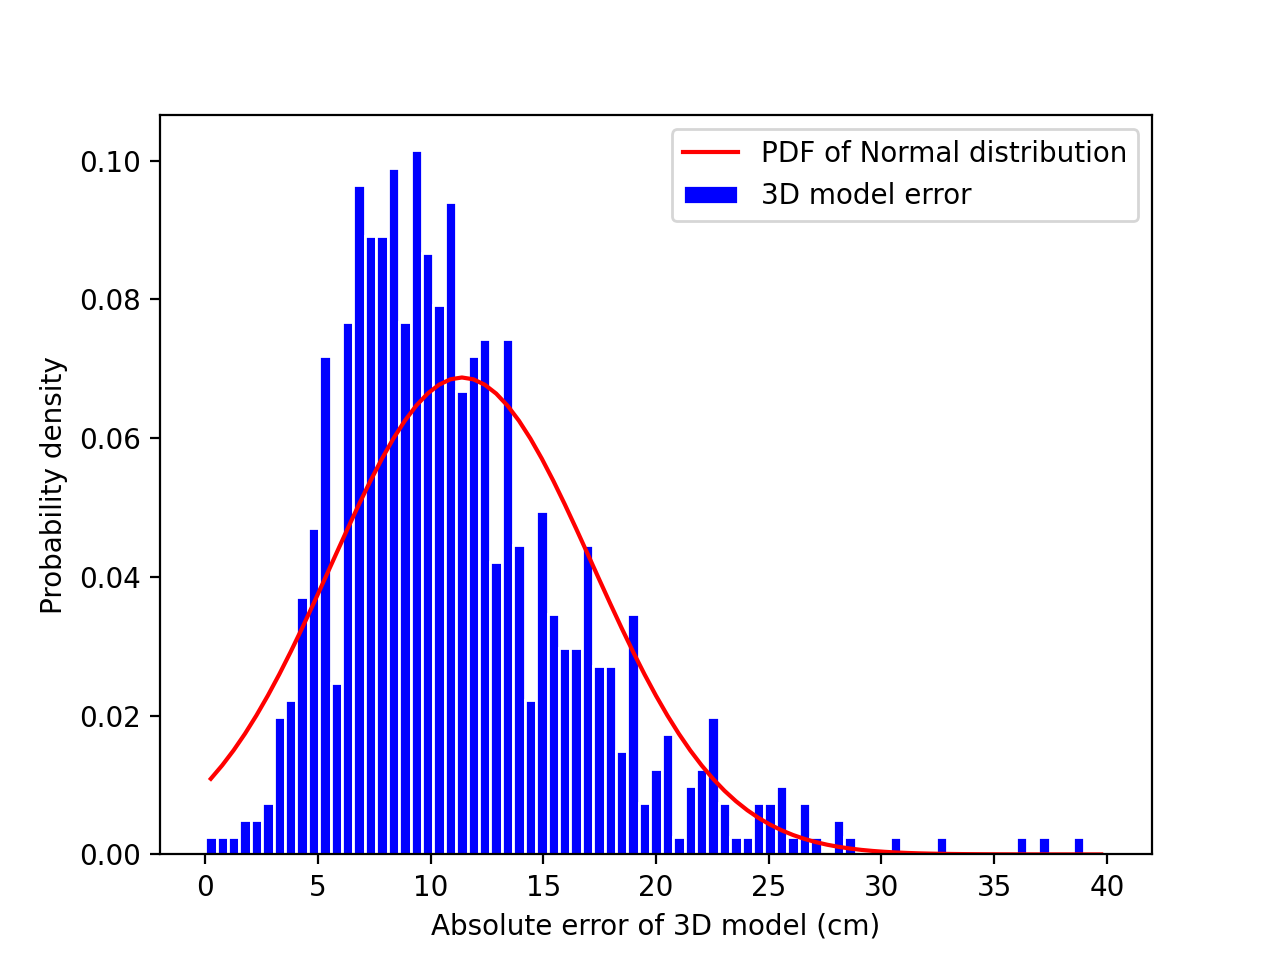

In [72]:
fig, ax1 = plt.subplots()

ax1.hist(error_3D, bins=bins, label='3D model error', color='b', density= 'true', stacked='true', edgecolor='w')
ax1.plot(bin_centers, norm_pdf_error3D, label="PDF of Normal distribution", color='r')
ax1.set_xlabel('Absolute error of 3D model (cm)')
ax1.set_ylabel('Probability density')

ax1.legend()

plt.show()

<IPython.core.display.Javascript object>


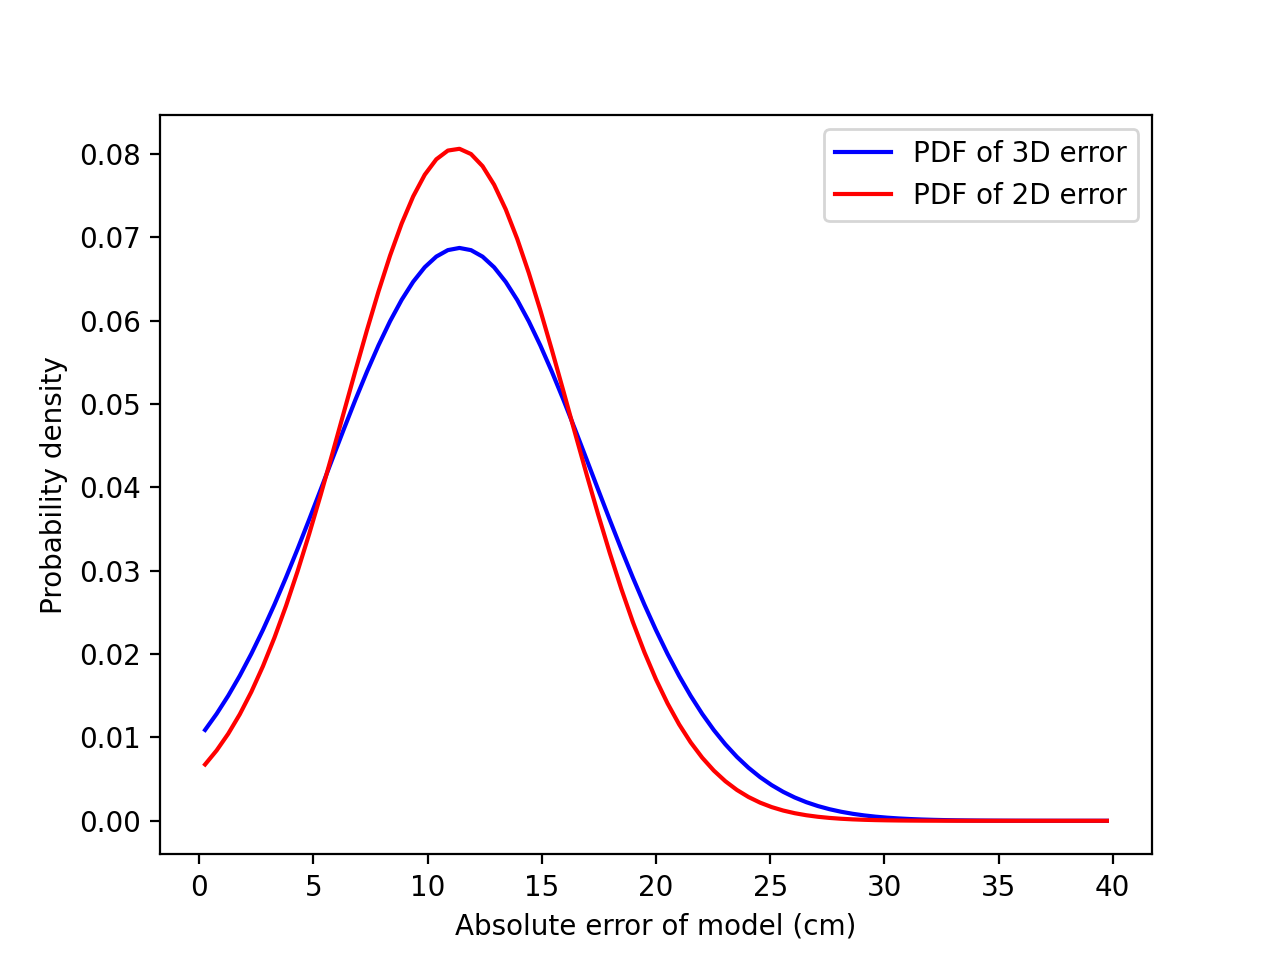

In [73]:
fig, ax1 = plt.subplots()

ax1.plot(bin_centers, norm_pdf_error3D, label="PDF of 3D error", color='b')
ax1.plot(bin_centers, norm_pdf_error2D, label="PDF of 2D error", color='r')
ax1.set_xlabel('Absolute error of model (cm)')
ax1.set_ylabel('Probability density')

ax1.legend()

plt.show()